# Main Analysis

## Imports

In [1]:
import pandas as pd
from pandas import DataFrame
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import scipy.stats as stats
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import pingouin as pg

## Variable Definitions and Constants

Here I declare all necessary variables and constants. This includes the snippet names as well as the correct answers for each snippet. I further add the possible variations.

### Constants

In [2]:
snippet_answer: dict[str, str] = {
	'arrayAverage': '4.0', 
	'binarySearch': '1', 
	'binaryToDecimal': '13', 
	'bubbleSort': '[1,2,3,4,5]', 
	'capitalizeFirstLetter': 'Hello World', 
	'commonChars': '2', 
	'containsSubstring': 'True', 
	'countIntegerInterval': '4', 
	'countLetters': '4',
	'crossSum': '16',
	'factorial': '24', 
	'forwardBackward': 'pricelesssselecirp', 
	'leastCommonMultiple': '30',
	'linearSearch': '1',
	'palindrome': 'True', 
	'power': '8',
	'prime': 'True', 
	'squareRoot': '[3.0, 5.0, 4.0, 10.0]', 
	'unrolledSort': '[8, 9, 11, 12]', 
	'validParentheses': 'False',
	'WarmUp': 'oefl',
}

possible_variations: dict[str, list[str]] = {
	'group_meaningful': ['MT', 'MN'],
	'group_meaningless': ['LT', 'LN'],
}

# The following lists are used to create a dataframe for the General Information
studentQuestions: list[str] = [
	'StudyBefore',
	'Job',
	'CourseOfStudy',
	'Semester',
	'Algorithms',
	'NrFalseInputs_studentQuestions',
]
progQuestions: list[str] = [
	'YearsProgramming',
	'ProgrammingLately',
	'ProgrammingLanguages',
	'RecentProgrammingLanguages',
	'PythonProgramming',
	'OverallExperience',
	'Classmates',
	'NrFalseInputs_progQuestions',
]
generalQuestions: list[str] = [
	'Age',
	'Gender',
	'Eyesight',
	'NrFalseInputs_generalQuestions',
]
miscellaneous_general_information: list[str] = [
	'ActualScreenWidth',
	'ActualScreenHeight',
	'EyeXScreenWidth',
	'EyeXScreenHeight',
	'SubjectID',
]

# The following lists are used to create a dataframe for the Correctness and Time Data
resultsOverall: list[str] = [
	'Number',
	'Task',
	'Answer_Out',
	'Time',
	'TimeOut',
	'SubjectID',
	'CorrectAnswer',
	'Meaningful',
	'TypeAnnotation',
]

necessary_columns: list[str] = [
	'ID',
]

meta_data_columns: list[str] = [
    'GazeData', 
    'GazeDataFilled', 
    'PersonalInformation', 
    'ResultsOverall', 
    'PostQuestionnaire', 
    'DifficultyRating', 
    'InterviewData', 
    'OverallTime', 
    'Meaningful', 
    'Finished', 
    'NumberOfMissingSnippets', 
    'TrialData',
]

likert_mapping: dict[str, int] = {
    'Very Inexperienced': 0,
    'Inexperienced': 1,
    'Neutral': 2,
    'Experienced': 3,
    'Very Experienced': 4,
}

figure_path = './figures/'

difficulty_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
experience_type = CategoricalDtype(categories=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'], ordered=True)

### Global Definitions

In [3]:
participants: list[str] = [] # list of participant numbers
meaningful_participants: list[str] = [] # list of participant numbers who were assigned to the meaningful group
meaningless_participants: list[str] = [] # list of participant numbers who were assigned to the meaningless group

df_personal_information: DataFrame = pd.DataFrame(columns=necessary_columns + generalQuestions + studentQuestions + progQuestions + miscellaneous_general_information)
df_meta_data: DataFrame = pd.DataFrame(columns=necessary_columns + meta_data_columns)
df_difficulty_rating: DataFrame = pd.DataFrame(columns=['ID', 'Task', 'Difficulty', 'Comment'])
df_subjective_feelings: DataFrame = pd.DataFrame()

### Generally helpful Functions

Enter a plot and give it a new color.

In [4]:
def define_box_properties(plot_name, color_code, label, axis = None):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend
    if axis is not None:
        axis.plot([], c=color_code, label=label)
        axis.legend()
    else:
        plt.plot([], c=color_code, label=label)
        plt.legend()

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

## Read in all data

This includes:
- [x] ~~Gaze Data~~
- [x] ~~Individual Summary~~
- [x] ~~Personal Information~~
- [x] ~~Correctness and Time~~
- [x] ~~Interview Data~~

First we need to find all possible folders and files. They are located in `Participants`.

### All Participants

In [5]:
# TODO: add also the new Participants
participants: list[str]  = sorted(os.walk('./AllParticipants').__next__()[1])
df_meta_data['ID'] = participants

### Check for all files

Collect all files that are present and collect which are still missing.

In [6]:
#  please check if file '`ID` PostQuestionaire.pdf' exists
for participant in participants:
    # check if '`ID` Post-Questionnaire.pdf' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/{participant} Post-Questionnaire.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PostQuestionnaire'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PostQuestionnaire'] = True
    
    # check if '`ID`' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/DifficultyRating_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'DifficultyRating'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'DifficultyRating'] = True
    
    # check if the folder 'Trial_`ID`' exists
    if not os.path.isdir(f'./AllParticipants/{participant}/Trial_{participant}'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'TrialData'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'TrialData'] = True
    
    # check if 'GeneralInfo_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/GeneralInfo_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PersonalInformation'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PersonalInformation'] = True
    
    # check if 'ResultsOverall_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/ResultsOverall_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'ResultsOverall'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'ResultsOverall'] = True
    
    # check if 'GazeData_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/GazeData_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'GazeData'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'GazeData'] = True

Print all Meta Information about Files concerning the study itself.

In [7]:
# print the count of False GazeData vs the count of True GazeData and show which ones are currently missing
gaze_data_count = df_meta_data['GazeData'].value_counts()
print('{:<32} {:2}/{:>2}'.format('GazeDataFiles found:', gaze_data_count[True], len(df_meta_data['GazeData'])))

# print the count of False PersonalInformation vs the count of True PersonalInformation and show which ones are currently missing
personal_information_count = df_meta_data['PersonalInformation'].value_counts()
print('{:<32} {:2}/{:>2}'.format('PersonalInformationFiles found:', personal_information_count[True], len(df_meta_data['PersonalInformation'])))

# print the count of False ResultsOverall vs the count of True ResultsOverall and show which ones are currently missing
results_overall_count = df_meta_data['ResultsOverall'].value_counts()
print('{:<32} {:2}/{:>2}'.format('ResultsOverallFiles found:', results_overall_count[True], len(df_meta_data['ResultsOverall'])))

# print the count of False PostQuestionnaire vs the count of True PostQuestionnaire and show which ones are currently missing
post_questionnaire_count = df_meta_data['PostQuestionnaire'].value_counts()
print('{:<32} {:2}/{:>2}'.format('PostQuestionnaireFiles found:', post_questionnaire_count[True], len(df_meta_data['PostQuestionnaire'])))

# print the count of False DifficultyRating vs the count of True DifficultyRating and show which ones are currently missing
difficulty_rating_count = df_meta_data['DifficultyRating'].value_counts()
print('{:<32} {:2}/{:>2}'.format('DifficultyRatingFiles found:', difficulty_rating_count[True], len(df_meta_data['DifficultyRating'])))

# print the count of False TrialData vs the count of True TrialData and show which ones are currently missing
trial_data_count = df_meta_data['TrialData'].value_counts()
print('{:<32} {:2}/{:>2}'.format('TrialDataFolders found:', trial_data_count[True], len(df_meta_data['TrialData'])))

# print which ones are missing
print('{:56} {}'.format('The following participants have no GazeData:', list(df_meta_data.loc[df_meta_data['GazeData'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no PersonalInformation:', list(df_meta_data.loc[df_meta_data['PersonalInformation'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no ResultsOverall:', list(df_meta_data.loc[df_meta_data['ResultsOverall'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no PostQuestionnaire:', list(df_meta_data.loc[df_meta_data['PostQuestionnaire'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no DifficultyRating:', list(df_meta_data.loc[df_meta_data['DifficultyRating'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no TrialData:', list(df_meta_data.loc[df_meta_data['TrialData'] == False, 'ID'].values)))

GazeDataFiles found:             40/40
PersonalInformationFiles found:  40/40
ResultsOverallFiles found:       40/40
PostQuestionnaireFiles found:    40/40
DifficultyRatingFiles found:     40/40
TrialDataFolders found:          40/40
The following participants have no GazeData:             []
The following participants have no PersonalInformation:  []
The following participants have no ResultsOverall:       []
The following participants have no PostQuestionnaire:    []
The following participants have no DifficultyRating:     []
The following participants have no TrialData:            []


Clean the `df_meta_data` DataFrame of columns that are no longer needed.

In [8]:
unnecessary_columns_meta_data: list[str] = [
    'GazeData', 
    'PersonalInformation', 
    'ResultsOverall', 
    'PostQuestionnaire', 
    'DifficultyRating', 
    'TrialData',
]

# remove unnecessary columns from df_meta_data
try:
    df_meta_data.drop(columns=unnecessary_columns_meta_data, inplace=True)

except:
    pass

### Personal Information

I read in all data from the files containing the personal information (`GeneralInfo_{ID}`) and add the `ID` for the participant.

In [9]:
for i in range(0, len(participants)):
	try:
		df_personal_information.loc[i] = pd.read_csv(f'./AllParticipants/{participants[i]}/Trial_{participants[i]}/GeneralInfo_{participants[i]}.csv', sep=';').iloc[0]
		df_personal_information.loc[i, 'ID'] = participants[i]
		df_meta_data.loc[i, 'PersonalInformation'] = True
		
	except:
		print(f'Participant {participants[i]} has no GeneralInfo.csv file')
		df_meta_data.loc[i, 'PersonalInformation'] = False

# write personal_information into a csv
df_personal_information.to_csv(f'./eyetracking/studies/Linearity/GeneralInfo_AllParticipants.csv', sep=';', index=False)

### Difficulty Rating

Read in all the difficulty rating to merge it later on into the results DataFrame

In [10]:
for i in range(0, len(participants)):
	try:
		df_to_add = pd.read_csv(f'./AllParticipants/{participants[i]}/DifficultyRating_{participants[i]}.csv', sep=';')
		if not all([x in snippet_answer.keys() for x in df_to_add["Task"]]):
			print(f'Participant {participants[i]} has a problem in the DifficultyRating file; these names {[x for x in df_to_add["Task"] if x not in snippet_answer.keys()]} are not in the snippet_answer dictionary')

		df_to_add['ID'] = participants[i]
		df_difficulty_rating = pd.concat([df_difficulty_rating, df_to_add], ignore_index=True)
	except:
		pass

df_difficulty_rating['Difficulty'] = df_difficulty_rating['Difficulty'].astype(difficulty_type)

# df_difficulty_rating

### Subjective Feelings

Read in all subjective feelings to merge it later on into the personal information DataFrame

In [11]:
for i in range(0, len(participants)):
    try:
        df_to_add = pd.read_csv(f'./AllParticipants/{participants[i]}/{participants[i]} Post-Questionnaire.csv', sep=';')
        df_to_add['ID'] = participants[i]
        df_subjective_feelings = pd.concat([df_subjective_feelings, df_to_add], ignore_index=True)
    except:
        pass

#### Data Cleaning for Personal Information

We can drop all columns that contain the number of false Inputs. We can further remove anyone who is currently not in their Bachelor's degree. These people shall be mentioned to see if they incorrectly filled out the form.

In [12]:
unnecessary_columns_gen_info: list[str] = [
	'NrFalseInputs_studentQuestions',
	'NrFalseInputs_progQuestions',
	'NrFalseInputs_generalQuestions',
]

# remove unnecessary columns
try:
	df_personal_information.drop(columns=unnecessary_columns_gen_info, inplace=True)

except:
	pass

# remove participants that are not currently in their bachelor but also mention them
#print(df_personal_information.query('Job != "Undergraduate Student (Bachelor Studies)"')['ID'])
#df_personal_information.drop(df_personal_information[df_personal_information['Job'] != 'Undergraduate Student (Bachelor Studies)'].index, inplace=True)

df_personal_information['PythonProgramming'] = df_personal_information['PythonProgramming'].astype(experience_type)
df_personal_information['OverallExperience'] = df_personal_information['OverallExperience'].astype(experience_type)
df_personal_information['Classmates'] = df_personal_information['Classmates'].astype(experience_type)

category_mapping = {'Very Inexperienced': 1, 'Inexperienced': 2, 'Average': 3, 'Experienced': 4, 'Very Experienced': 5}
df_personal_information['Classmates'] = df_personal_information['Classmates'].map(category_mapping)
df_personal_information['PythonProgramming'] = df_personal_information['PythonProgramming'].map(category_mapping)
df_personal_information['OverallExperience'] = df_personal_information['OverallExperience'].map(category_mapping)

df_personal_information

,ID,Age,Gender,Eyesight,StudyBefore,Job,CourseOfStudy,Semester,Algorithms,YearsProgramming,...,ProgrammingLanguages,RecentProgrammingLanguages,PythonProgramming,OverallExperience,Classmates,ActualScreenWidth,ActualScreenHeight,EyeXScreenWidth,EyeXScreenHeight,SubjectID
0,10066,21,Male,No,No,Undergraduate Student (Bachelor Studies),BCs. Informatik,4,No,2,...,"Java, Python, C/++, Javascript",Java,3,3,3,2560,1440,2560,1440,b167d432-eef9-4501-ad8e-f0daba01c76d
1,10723,23,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,9,No,11,...,"Python, Java, Javascript, R, C, C++","Python, Java, Javascript, R, C, C++",4,4,4,2560,1440,2560,1440,779e5d3b-19a0-4a8a-97d2-3d9df0166780
2,10920,21,Male,No,No,Undergraduate Student (Bachelor Studies),DSAI,6,No,3,...,Python,"Python, C#",4,3,4,2560,1440,2560,1440,1f719d25-bbad-4d99-8ce4-84dae28cec82
3,12480,22,Male,No,No,Undergraduate Student (Bachelor Studies),B. Sc. Business Informatics,5,No,4,...,"Java, C, C++, C#, JS, Python, PHP","Java, C, C++, JS, Python, PHP",3,4,4,2560,1440,2560,1440,ca433995-88ff-43cc-9c55-14a075199cf7
4,12663,20,Male,"Yes, but with glasses/contact lenses I have 100%",No,Undergraduate Student (Bachelor Studies),Bachelors Plus MINT,1,No,1,...,"Python, OCaml",OCaml,2,3,1,2560,1440,2560,1440,03dc81fa-df7b-4101-aa48-6a1cabb58ce9
5,13020,24,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,3,No,2,...,"Python, Java, C, OCaml",Python,2,2,3,2560,1440,2560,1440,1cbabb88-1cd3-40ce-a008-a109ea7eb091
6,14296,21,Female,No,Yes,Undergraduate Student (Bachelor Studies),Informatik B.Sc,7,No,6,...,"Java, Python, little bit C & R","Java, R",2,3,2,2560,1440,2560,1440,c91e49ab-3eb2-470b-8a1a-e4d474d3c3ed
7,18457,26,Male,"Yes, but with glasses/contact lenses I have 100%",Yes,Undergraduate Student (Bachelor Studies),DSAI,10,No,5,...,"Python, Java, C, ...",Python,4,4,4,2560,1440,2560,1440,14cdf899-d89b-4795-8956-494330715bcd
8,18868,20,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersicherheit,1,No,5,...,"Python, C, Java, (OCaml, MIPS, Lazarus slightly)","Python, OCaml",4,3,3,2560,1440,2560,1440,de29c929-1874-451b-9d1d-bc96e7552246
9,23559,21,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,7,No,5,...,"R, Python, MIPS, C, Java, html, css, sql","R, Python, html, sql",2,4,3,2560,1440,0,0,f15e8ac2-fdde-4c2e-8927-59a9cbf23e7e


#### Subjective Difficulty Merging

Merging the subjective feelings into the personal information 

In [13]:
# merge personal information and the subjective feelings
df_personal_information = pd.merge(df_personal_information, df_subjective_feelings, how='left', left_on=['ID'], right_on=['ID'])

# df_personal_information


### Cleaning of the personal information

1. Correct and throw out the Bachelor students
2. Correct and throw out any person that is not in CS-related courses of study
3. Throw out anyone under the age of 18

In [14]:
course_of_study_mapping: dict[str, str] = {
    'cs': 'Computer Science',
    'CS': 'Computer Science',
    'BCs. Informatik': 'Computer Science',
    'Cybersicherheit': 'Cybersecurity',
    'DSAI': 'Data Science and Artificial Intelligence',
    'B. Sc. Business Informatics': 'Business Informatics',
    'Informatik B.Sc': 'Computer Science',
    'Eingebettete Systeme': 'Embedded Systems',
    'Informatik': 'Computer Science',
    'Math and Computer Science': 'Mathematics and Computer Science',
    'Computer Science (German)': 'Computer Science',
    'Mathematik und Informatik': 'Mathematics and Computer Science',
    'Medieninformatik': 'Media Informatics',
    'medieninfo': 'Media Informatics',
    'Informatics': 'Computer Science',
    'Informatik Kernbereich': 'Computer Science',
    'Eingebettete Systeme B.Sc.': 'Embedded Systems',
    'Computerlinguistik B.Sc.': 'Computational Linguistics',
    'materialise science': 'Material Science'
}

possible_courses_of_study: list[str] = ['Computer Science', 
                                        'Cybersecurity', 
                                        'Business Informatics', 
                                        'Data Science and Artificial Intelligence',
                                        'Mathematics and Computer Science',
                                        'Media Informatics',
                                        'Embedded Systems',
                                        'Bioinformatics',
                                        'Computational Linguistics',
                                        ]

# check the age and throw out anyone under the age of 18
print(f'Have to drop {df_personal_information.query("Age < 18")["ID"].tolist()} because they were under the age of 18')
df_personal_information.drop(df_personal_information[df_personal_information['Age'] < 18].index, inplace=True)

# check and throw out anyone that is not a bachelors student
#non_bachelors: list[str] = df_personal_information.query("Job != 'Undergraduate Student (Bachelor Studies)'")["ID"].tolist()
#print(f'Have to drop {non_bachelors} because they were not in their Bachelors')
#df_personal_information.drop(df_personal_information[df_personal_information['Job'] != 'Undergraduate Student (Bachelor Studies)'].index, inplace=True)

# normalize all the course of study values
df_personal_information['CourseOfStudy'].replace(course_of_study_mapping, inplace=True)
print(f'Have to drop {df_personal_information[~df_personal_information["CourseOfStudy"].isin(possible_courses_of_study)]["CourseOfStudy"].tolist()} because they were not in the course of study mapping')
df_personal_information.drop(df_personal_information[~df_personal_information['CourseOfStudy'].isin(possible_courses_of_study)].index, inplace=True)

# check and throw out anyone that is not studying computer science related fields
non_cs_students: list[str] = df_personal_information.query("CourseOfStudy != @possible_courses_of_study")["CourseOfStudy"].tolist()
print(f'Have to drop {len(non_cs_students)} {non_cs_students} because they were not studying Computer Science')

participants = df_personal_information['ID'].unique().tolist()

# change columns to numeric value
df_personal_information['Age'] = pd.to_numeric(df_personal_information['Age'])
df_personal_information['Semester'] = pd.to_numeric(df_personal_information['Semester'])
df_personal_information['YearsProgramming'] = pd.to_numeric(df_personal_information['YearsProgramming'])
df_personal_information['Eyesight'] = df_personal_information['Eyesight'].astype("category")
df_personal_information['Gender'] = df_personal_information['Gender'].astype("category")

Have to drop [] because they were under the age of 18
Have to drop ['Bachelors Plus MINT', 'Material Science', 'Systems Engineering'] because they were not in the course of study mapping
Have to drop 0 [] because they were not studying Computer Science


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/4118174361.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_personal_information['CourseOfStudy'].replace(course_of_study_mapping, inplace=True)


### Correctness and Time

I read in all data from the files containing the results (`ResultsOverall_{ID}`) and add the `ID` for the participant.

In [15]:
df_results_overall: DataFrame = pd.DataFrame(columns=necessary_columns + resultsOverall)

for i in range(0, len(participants)):

	df_to_add_general: DataFrame = DataFrame()

	# check if the participant has finished all snippets and read in the results data
	try:
		df_to_add: DataFrame = pd.read_csv(f'./AllParticipants/{participants[i]}/Trial_{participants[i]}/ResultsOverall_{participants[i]}.csv', sep=';').assign(ID=participants[i])

		if df_to_add['Answer_Out'].isnull().values.any():
			print(f'Participant {participants[i]} did not finish all snippets')
			df_meta_data.loc[i, 'Finished'] = False
		else:
			df_meta_data.loc[i, 'Finished'] = True

		df_to_add['ID'] = participants[i]
		df_results_overall = pd.concat([df_results_overall, df_to_add], ignore_index=True)

		df_meta_data.loc[i, 'ResultsOverall'] = True

	except:
		print(f'Participant {participants[i]} has no ResultsOverall.csv file')
		df_meta_data.loc[i, 'ResultsOverall'] = False

# now get the values from the eyetracking and merge it into the dataframe
# TODO: this file does not yet exist, create it first
df_eye_tracking_metrics: DataFrame = pd.read_csv(f'./eyetracking/output/AOI/Metrics_Data_for_Anova.csv', sep=';')
df_results_overall['SubjectID'] = df_results_overall['SubjectID'].apply(lambda x: x[:8])
df_results_overall = pd.merge(df_results_overall, df_eye_tracking_metrics, how='left', left_on=['SubjectID', 'Task'], right_on=['Participant', 'Snippet'])


# sort the dataframe by the participant `ID` and `Number`
df_results_overall.sort_values(by=['ID', 'Number'], inplace=True)

Participant 13020 did not finish all snippets
Participant 14296 did not finish all snippets
Participant 23559 did not finish all snippets
Participant 24341 did not finish all snippets
Participant 31195 did not finish all snippets
Participant 66723 did not finish all snippets


Add the meaningful tag to the personal information dataframe

#### Data Cleaning for Correctness and Time

We can drop the column `SubjectID` and turn the `Time` column into seconds.

In [16]:
unnecessary_columns_overall_results: list[str] = [
	'SubjectID',
	'Number',
	'Participant',
	'Expert',
	'ExecOrder_Naive_Score',
	'ExecOrder_Dynamic_Score', 
	'ExecOrder_Dynamic_Repetitions',
	'Snippet',
]

# remove unnecessary columns
try:
	df_results_overall.drop(columns=unnecessary_columns_overall_results, inplace=True, ignore_index=True)
except:
	pass

# Show whether a participant did all snippets or if they ran into a timeout
for i in range(0, len(participants)):
	if df_results_overall.query(f'ID == "{participants[i]}"')['Answer_Out'].isnull().values.any():
		number_of_missing_snippets: int = df_results_overall.query(f'ID == "{participants[i]}"')["Answer_Out"].isnull().sum()
		print(f'Participant {participants[i]} did not finish all snippets, they missed {number_of_missing_snippets} snippets.')
		df_meta_data.loc[i, 'NumberOfMissingSnippets'] = number_of_missing_snippets
	else:
		df_meta_data.loc[i, 'NumberOfMissingSnippets'] = 0

	if df_results_overall.query(f'ID == "{participants[i]}"')['TimeOut'].any():
		print(f'Participant {participants[i]} ran into a timeout.')
	
	

# drop any line that has a `Time` value of 0
df_results_overall: DataFrame = df_results_overall[df_results_overall['Time'] != 0]

# drop every line that has a `Task` value of `WarmUp`
df_results_overall: DataFrame = df_results_overall[df_results_overall['Task'] != 'WarmUp']

# turn the `Time` column into seconds as it is currently in milliseconds
df_results_overall['Time'] = df_results_overall['Time'].apply(lambda x: x // 1000 if x > 1000 else x)

# fill the columns `Meaningful` and `Type Annotation` with the correct values
df_results_overall['Meaningful'] = df_results_overall['Task'].apply(lambda x: True if x[-2] == 'M' else False)
df_results_overall['TypeAnnotation'] = df_results_overall['Task'].apply(lambda x: True if x[-1] == 'T' else False)

# set the column of Meaningful to True if the participant has at least one meaningful snippet
df_meta_data['Meaningful'] = df_meta_data.apply(lambda x: True if df_results_overall.query(f'ID == "{x["ID"]}"')['Meaningful'].any() else False, axis=1)

# save which of the participants were assigned to the respective groups
meaningful_participants = df_meta_data.query('Meaningful == True')['ID'].values
meaningless_participants = df_meta_data.query('Meaningful == False')['ID'].values

# remove the last two letters from the `Task` column
df_results_overall['Task'] = df_results_overall['Task'].apply(lambda x: x[:-2] if x[-2] == 'M' or x[-2] == 'L' else x)

# compute if the correct answer was given for each `Task` and `ID` and add it to `CorrectAnswer`
df_results_overall['CorrectAnswer'] = df_results_overall.apply(lambda x: True if snippet_answer[x['Task']] == x['Answer_Out'] else False, axis=1)

Participant 13020 did not finish all snippets, they missed 8 snippets.
Participant 14296 did not finish all snippets, they missed 1 snippets.
Participant 23559 did not finish all snippets, they missed 3 snippets.
Participant 24341 did not finish all snippets, they missed 1 snippets.
Participant 31195 did not finish all snippets, they missed 12 snippets.
Participant 31195 ran into a timeout.
Participant 66723 did not finish all snippets, they missed 2 snippets.


Now merge `df_results_overall` and `df_difficulty_rating` and also merge `personal_information` and the `Meaningful` columns of `df_results_overall`.

In [17]:
df_results_overall = pd.merge(df_results_overall, df_difficulty_rating, how='left', left_on=['ID','Task'], right_on=['ID','Task'])

#### Computations for Correctness and Time

First, we create a general overview of the tables data.

We compute the time taken for each `Task` for each participant `ID`.

In [18]:
aggregation_computation: dict[str, str] = {
    'CorrectAnswer': [np.count_nonzero,],
    'TypeAnnotation': ['count',],
    'Time': ['mean', 'median', 'min', 'max', 'sum',],
}

overview_correctness_time: DataFrame = df_results_overall.groupby(['ID', 'Meaningful', 'TypeAnnotation']).agg(aggregation_computation).reset_index()

overview_correctness_time

ID Meaningful TypeAnnotation CorrectAnswer TypeAnnotation       Time  \
                                    count_nonzero          count       mean   
0   10066       True          False             7              9  51.111111   
1   10066       True           True            10             11  44.000000   
2   10723      False          False             8              8  87.750000   
3   10723      False           True            12             12  92.333333   
4   10920       True          False             8              9  44.777778   
..    ...        ...            ...           ...            ...        ...   
69  74390      False           True            12             13  59.615385   
70  76211      False          False             3              7  37.000000   
71  76211      False           True             8             13  57.846154   
72  93795      False          False             8              9  49.222222   
73  93795      False           True             8             11  73.818182   

                          
   median min  max   sum  
0    45.0  13  128   460  
1    30.0  22   94   484  
2    72.0  35  157   702  
3    78.5  27  223  1108  
4    39.0   9   87   403  
..    ...  ..  ...   ...  
69   64.0  14   94   775  
70   24.0  13  126   259  
71   54.0  13  142   752  
72   48.0   8  102   443  
73   60.0  33  136   812  

[74 rows x 10 columns]

Add the meaningful and meaningless values to the personal information DataFrame.

In [19]:
df_personal_information['Meaningful'] = df_personal_information['ID'].apply(lambda x: True if x in meaningful_participants else False)

df_personal_information

,ID,Age,Gender,Eyesight,StudyBefore,Job,CourseOfStudy,Semester,Algorithms,YearsProgramming,...,FeelingStudy,FeelingStudyComment,ProblemSolvingStrategies,ChangeComprehension,TAComprehension,TAComprehensionComment,TAComprehensionGeneral,TAComprehensionGeneralComment,LaterCodeSnippets,Meaningful
0,10066,21,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,4,No,2,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
1,10723,23,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,9,No,11,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,False
2,10920,21,Male,No,No,Undergraduate Student (Bachelor Studies),Data Science and Artificial Intelligence,6,No,3,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
3,12480,22,Male,No,No,Undergraduate Student (Bachelor Studies),Business Informatics,5,No,4,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
5,13020,24,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,3,No,2,...,3,NaN,NaN,NaN,False,NaN,True,NaN,NaN,True
6,14296,21,Female,No,Yes,Undergraduate Student (Bachelor Studies),Computer Science,7,No,6,...,2,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
7,18457,26,Male,"Yes, but with glasses/contact lenses I have 100%",Yes,Undergraduate Student (Bachelor Studies),Data Science and Artificial Intelligence,10,No,5,...,2,NaN,- Immediately stopped depending on the variabl...,Yes. I mentioned them in 4 (see above).,True,- enable classifying the code as a manipulatio...,True,- know the expected type of specification (exp...,later,False
8,18868,20,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,1,No,5,...,2,wenig geschlafen,NaN,NaN,True,NaN,True,NaN,NaN,False
9,23559,21,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,7,No,5,...,2,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
10,23993,22,Male,"Yes, but with glasses/contact lenses I have 100%",No,Undergraduate Student (Bachelor Studies),Embedded Systems,9,Yes,5,...,2,NaN,NaN,NaN,True,NaN,True,NaN,NaN,False


In [20]:
df_results_overall.groupby(['ID', 'Task']).agg({'Time': 'mean'}).unstack().T.fillna('-')

ID                          10066  10723  10920  12480  13020  14296  18457  \
     Task                                                                     
Time arrayAverage            22.0  109.0   39.0   27.0      -   69.0   63.0   
     binarySearch            35.0  145.0   37.0   81.0  176.0  223.0  104.0   
     binaryToDecimal         62.0  121.0   74.0  245.0  121.0   94.0   43.0   
     bubbleSort              45.0  157.0   39.0   79.0  164.0      -   97.0   
     capitalizeFirstLetter   27.0  123.0   59.0   66.0      -  106.0  102.0   
     commonChars             33.0   53.0   34.0   45.0   82.0   37.0   42.0   
     containsSubstring       32.0  223.0   87.0   40.0  164.0  124.0  167.0   
     countIntegerInterval    70.0   64.0   62.0   34.0      -   63.0   90.0   
     countLetters            28.0   73.0   35.0   44.0      -   78.0  106.0   
     crossSum                30.0   35.0   31.0   48.0   64.0   28.0   52.0   
     factorial               13.0   27.0    9.0   20.0      -   34.0   37.0   
     forwardBackward         75.0   84.0   52.0   56.0      -  220.0   94.0   
     leastCommonMultiple     22.0   67.0   23.0   96.0   83.0   98.0   65.0   
     linearSearch            27.0   38.0   13.0   11.0   61.0   46.0   38.0   
     palindrome              71.0   57.0   20.0   41.0      -   70.0   44.0   
     power                   28.0   50.0   21.0   35.0   80.0   80.0   37.0   
     prime                   94.0   77.0   38.0   76.0      -   91.0   47.0   
     squareRoot              49.0   62.0   48.0   98.0  275.0   82.0   89.0   
     unrolledSort            53.0   88.0   46.0  120.0   83.0  157.0  181.0   
     validParentheses       128.0  157.0  116.0  113.0   79.0  143.0  104.0   

ID                          18868  23559  23993  ...  54850  57736  59585  \
     Task                                        ...                        
Time arrayAverage            90.0   79.0   38.0  ...   61.0   57.0   28.0   
     binarySearch           146.0      -  177.0  ...   61.0   74.0   84.0   
     binaryToDecimal         60.0   77.0   89.0  ...   93.0   62.0   38.0   
     bubbleSort              49.0  173.0   67.0  ...  111.0   59.0   44.0   
     capitalizeFirstLetter   92.0  136.0   83.0  ...   95.0  126.0   81.0   
     commonChars            101.0   52.0  102.0  ...   31.0   53.0   34.0   
     containsSubstring      109.0   97.0  121.0  ...   78.0  194.0   44.0   
     countIntegerInterval    84.0  104.0  103.0  ...  105.0   59.0   49.0   
     countLetters            33.0   48.0  127.0  ...   66.0   63.0   57.0   
     crossSum                52.0      -   42.0  ...   22.0   38.0    9.0   
     factorial               23.0   37.0    9.0  ...   23.0   15.0    9.0   
     forwardBackward         91.0  100.0   76.0  ...   83.0   71.0   45.0   
     leastCommonMultiple     52.0   65.0   59.0  ...   65.0   22.0   36.0   
     linearSearch            23.0   25.0   35.0  ...   24.0   49.0   16.0   
     palindrome             120.0   86.0  189.0  ...   77.0   55.0   45.0   
     power                   47.0  112.0   13.0  ...   31.0  111.0   40.0   
     prime                   35.0   49.0   60.0  ...   61.0   80.0   39.0   
     squareRoot             131.0      -   80.0  ...   34.0  101.0   57.0   
     unrolledSort            20.0   95.0   34.0  ...   41.0   78.0   47.0   
     validParentheses        64.0  131.0  102.0  ...  131.0   93.0   70.0   

ID                          60682  62039  66723  67130  74390  76211  93795  
     Task                                                                    
Time arrayAverage            30.0   36.0   96.0   72.0   43.0   95.0   74.0  
     binarySearch            74.0   72.0  251.0  188.0   70.0  142.0   89.0  
     binaryToDecimal         44.0   35.0  119.0   57.0   88.0   31.0   48.0  
     bubbleSort              35.0   86.0  180.0  126.0   67.0   90.0   89.0  
     capitalizeFirstLetter   65.0   52.0  179.0  150.0   94.0   21.0  114.0  
     commonChars    

Now remove certain data points from response time. These are the highest 5%

In [21]:
# remove the outlier from the response time
print(f'95% quantile = {df_results_overall["Time"].quantile(0.95)} seconds')
print(f'5% quantile = {df_results_overall["Time"].quantile(0.05)} seconds')

q = df_results_overall['Time'].quantile(0.95)

df_results_overall = df_results_overall[df_results_overall['Time'] < q]
print(df_results_overall['Time'].describe())

# completely remove participant 31195
df_results_overall = df_results_overall[df_results_overall['ID'] != '31195']
df_personal_information = df_personal_information[df_personal_information['ID'] != '31195']
df_meta_data = df_meta_data[df_meta_data['ID'] != '31195']

95% quantile = 173.0 seconds
5% quantile = 19.0 seconds
count    676.000000
mean      65.434911
std       35.800396
min        8.000000
25%       38.000000
50%       59.000000
75%       88.000000
max      171.000000
Name: Time, dtype: float64


In [22]:
print(len(df_results_overall['ID'].value_counts()))

31


In [23]:
print(df_personal_information.CourseOfStudy.value_counts(normalize=True))

CourseOfStudy
Computer Science                            0.387097
Cybersecurity                               0.258065
Data Science and Artificial Intelligence    0.096774
Media Informatics                           0.096774
Embedded Systems                            0.064516
Mathematics and Computer Science            0.064516
Business Informatics                        0.032258
Name: proportion, dtype: float64


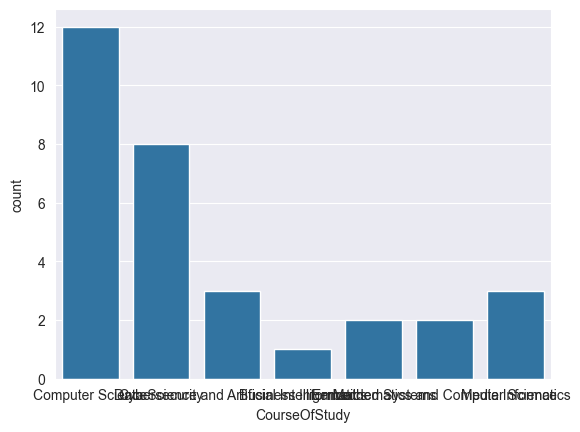

In [24]:
sns.countplot(df_personal_information, x='CourseOfStudy')
plt.show()


### People Distributions and Data

1. The age
2. Their experience
3. Their Course of Study

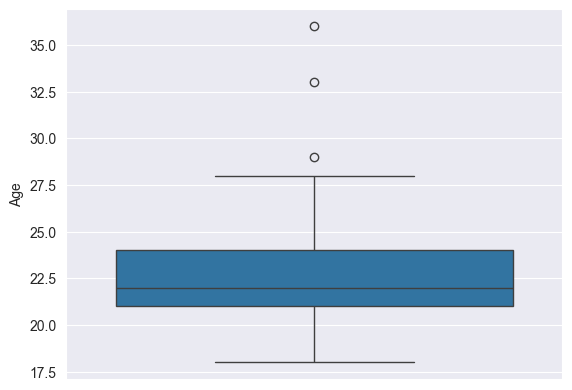

In [25]:
sns.boxplot(data=df_personal_information, y='Age',)
plt.show()

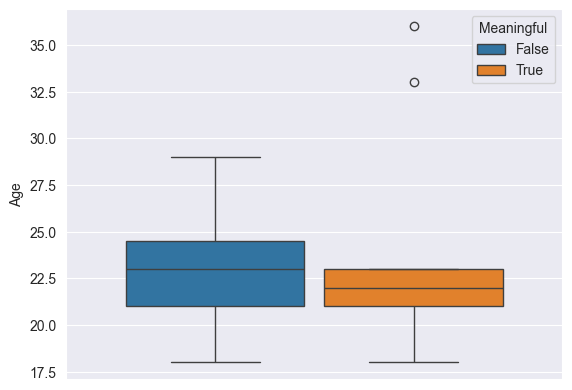

In [26]:
sns.boxplot(data=df_personal_information, y='Age', hue='Meaningful', gap=.1)
plt.show()

The courses of study

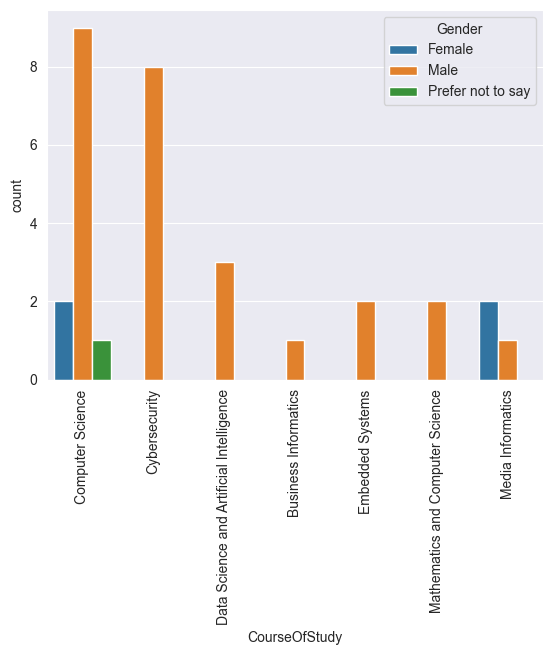

In [27]:
sns.countplot(data=df_personal_information, x='CourseOfStudy',hue='Gender')
plt.xticks(rotation=90)
plt.show()

The number of semesters

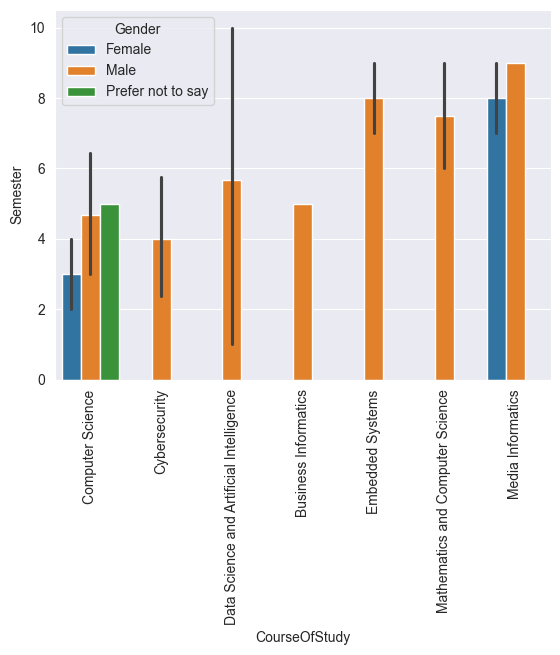

In [28]:
sns.barplot(data=df_personal_information, x='CourseOfStudy',hue='Gender', y='Semester')
plt.xticks(rotation=90)
plt.show()

The number of semesters in general

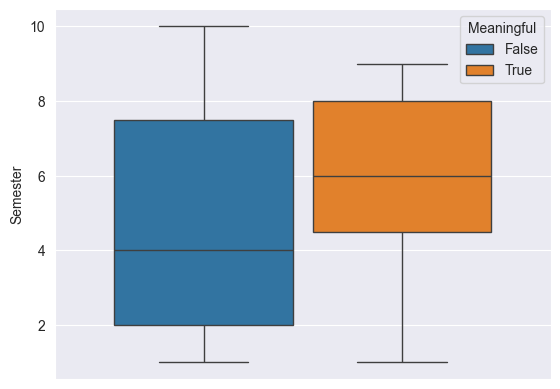

In [29]:
sns.boxplot(data=df_personal_information, y='Semester', hue='Meaningful', gap=.1,)
plt.show()

Classmates and overall experience

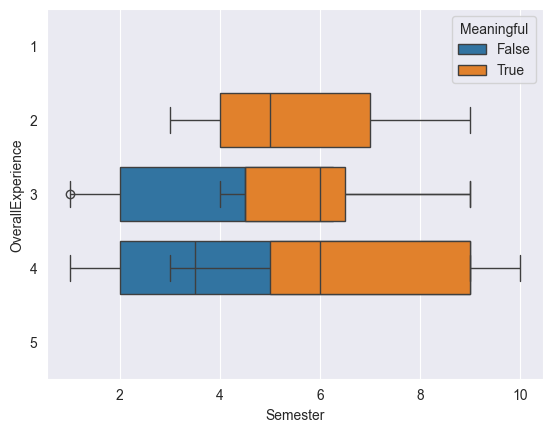

In [30]:
sns.boxplot(data=df_personal_information, y='OverallExperience', x='Semester', hue='Meaningful', gap=.1, 
            # order=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced']
            )
plt.show()

Classmates

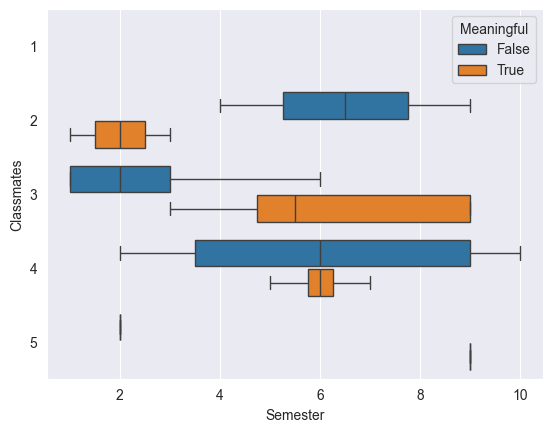

In [31]:
sns.boxplot(data=df_personal_information, 
            y='Classmates', 
            x='Semester', 
            hue='Meaningful', 
            gap=.1, 
            # order=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'],
            )
plt.show()

OverallExperience by ProgrammingLately

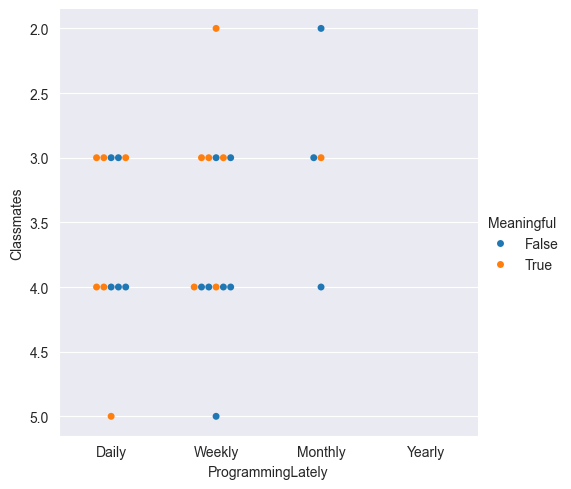

In [32]:
sns.catplot(data=df_personal_information,
            x='ProgrammingLately',
            y='Classmates',
            hue='Meaningful',
            # gap=.1,
            order=['Daily', 'Weekly', 'Monthly', 'Yearly'],
            kind='swarm'
            )
plt.show()

#### Standard Data for the personal information

In [33]:
print(f'Age:\n{df_personal_information["Age"].describe()}\n')
print(f'Semester:\n{df_personal_information["Semester"].describe()}\n')
print(f'YearsProgramming:\n{df_personal_information["YearsProgramming"].describe()}\n')
print(f'Gender:\n{df_personal_information.groupby("Gender").agg({"Gender": "count"})}\n')
print(f'Classmates:\n{df_personal_information.groupby("Classmates").agg({"Classmates": "count"})}\n')

Age:
count    31.000000
mean     23.193548
std       3.927844
min      18.000000
25%      21.000000
50%      22.000000
75%      24.000000
max      36.000000
Name: Age, dtype: float64

Semester:
count    31.000000
mean      5.258065
std       2.863189
min       1.000000
25%       3.000000
50%       5.000000
75%       8.000000
max      10.000000
Name: Semester, dtype: float64

YearsProgramming:
count    31.000000
mean      5.129032
std       2.717130
min       1.000000
25%       3.000000
50%       5.000000
75%       7.000000
max      11.000000
Name: YearsProgramming, dtype: float64

Gender:
                   Gender
Gender                   
Female                  4
Male                   26
Prefer not to say       1

Classmates:
            Classmates
Classmates            
1                    0
2                    4
3                   13
4                   12
5                    2



/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1011207774.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Gender:\n{df_personal_information.groupby("Gender").agg({"Gender": "count"})}\n')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1011207774.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Classmates:\n{df_personal_information.groupby("Classmates").agg({"Classmates": "count"})}\n')


Standard Data for personal information divided by Meaningful Data

In [34]:
print(f'Age:\n{df_personal_information.groupby("Meaningful").agg({"Age": ["mean", "std"]})}')
print(f'Semester:\n{df_personal_information.groupby("Meaningful").agg({"Semester": ["mean", "std"]})}\n')
print(f'YearsProgramming:\n{df_personal_information.groupby("Meaningful").agg({"YearsProgramming": ["mean", "std"]})}\n')
print(f'Gender:\n{df_personal_information.groupby(["Meaningful", "Gender"]).agg({"Gender": "count"})}\n')
print(f'EyeSight:\n{df_personal_information.groupby(["Meaningful", "Eyesight"]).agg({"Eyesight": "count"})}\n')
print(f'StudyBefore:\n{df_personal_information.groupby(["Meaningful", "StudyBefore"]).agg({"StudyBefore": "count"})}\n')

Age:
                  Age          
                 mean       std
Meaningful                     
False       23.312500  2.914761
True        23.066667  4.891197
Semester:
           Semester          
               mean       std
Meaningful                   
False          4.75  3.172801
True           5.80  2.484236

YearsProgramming:
           YearsProgramming          
                       mean       std
Meaningful                           
False              5.312500  2.891799
True               4.933333  2.604026

Gender:
                              Gender
Meaningful Gender                   
False      Female                  3
           Male                   13
           Prefer not to say       0
True       Female                  1
           Male                   13
           Prefer not to say       1

EyeSight:
                                                             Eyesight
Meaningful Eyesight                                                  
False     

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1644175717.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Gender:\n{df_personal_information.groupby(["Meaningful", "Gender"]).agg({"Gender": "count"})}\n')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1644175717.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'EyeSight:\n{df_personal_information.groupby(["Meaningful", "Eyesight"]).agg({"Eyesight": "count"})}\n')


Efficacy for every participant:


Efficacy of Participant ('10066', False): 1.1739130434782608
Efficacy of Participant ('10066', True): 1.3636363636363638
Efficacy of Participant ('10723', False): 0.6837606837606838
Efficacy of Participant ('10723', True): 0.7457627118644068
Efficacy of Participant ('10920', False): 1.3399503722084367
Efficacy of Participant ('10920', True): 1.375
Efficacy of Participant ('12480', False): 1.139240506329114
Efficacy of Participant ('12480', True): 0.8433734939759036
Efficacy of Participant ('18457', False): 0.903387703889586
Efficacy of Participant ('18457', True): 0.673076923076923
Efficacy of Participant ('18868', False): 0.8888888888888888
Efficacy of Participant ('18868', True): 0.8032128514056225
Efficacy of Participant ('23993', False): 1.0183875530410185
Efficacy of Participant ('23993', True): 0.675422138836773
Efficacy of Participant ('25574', False): 0.812807881773399
Efficacy of Participant ('25574', True): 0.8080808080808081
Efficacy of Participant ('25850', False): 0.667726

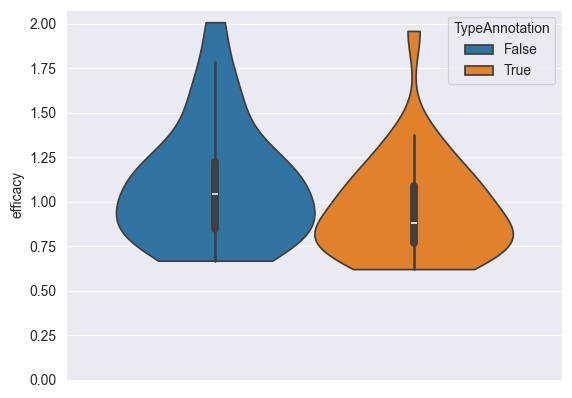

In [35]:
df = df_results_overall.groupby(['ID', 'TypeAnnotation']).agg({'Time': 'sum', 'CorrectAnswer': 'count'})
df['efficacy'] = df.CorrectAnswer / (df.Time / 60) 
# df.columns.droplevel(0)
# print(df)
for index, row in df.iterrows():
    print(f'Efficacy of Participant {index}: {row.CorrectAnswer / (row.Time / 60)}')

sns.violinplot(df, y='efficacy', hue='TypeAnnotation', cut=0)
plt.ylim(bottom=0)
plt.show()

Statistical Methods one after the other

In [36]:
from statsmodels.tsa.stattools import acf
def compute_statistics(data: DataFrame, with_TA, without_TA, input_type: str = 'continuous', output_type: str = 'contiuous', population: str = 'within', p_value: float = 0.05):

    # input_dependence: str = 'independent',

    # check for normality
    with_TA_normality = stats.shapiro(with_TA)
    without_TA_normality = stats.shapiro(without_TA)

    # print(with_TA)
    # print(without_TA)

    # check for homogeneity of variance
    homogeneity_of_variance = stats.levene(with_TA, without_TA)
    # print(homogeneity_of_variance)

    if with_TA_normality.pvalue > p_value and without_TA_normality.pvalue > p_value:
        print(f'Both groups are normally distributed with pvalues {with_TA_normality.pvalue} and {without_TA_normality.pvalue}')
    else:
        print(f'At least one group is not normally distributed with pvalues {with_TA_normality.pvalue} and {without_TA_normality.pvalue}')

    if homogeneity_of_variance.pvalue > p_value:
        print(f'Both groups have homogeneity of variance with pvalue {homogeneity_of_variance.pvalue}')
    else:
        print(f'Both groups do not have homogeneity of variance with pvalue {homogeneity_of_variance.pvalue}')

    if with_TA_normality.pvalue > p_value and without_TA_normality.pvalue > p_value and homogeneity_of_variance.pvalue > p_value:
        if population == 'within':
            if input_type == 'categorical' and output_type == 'continuous':
                print(f'TTEST_REL: {stats.ttest_rel(without_TA, with_TA)}')
            elif input_type == 'categorical' and output_type == 'categorical':
                print(f'CHISQUARE: {stats.chisquare(without_TA, with_TA)}')
            elif len(with_TA) == len(without_TA):
                print(f'WILCOXON TWO-SIDED: {stats.wilcoxon(without_TA, with_TA)}')
                print(f'WILCOXON ONE-SIDED Greater: {stats.wilcoxon(without_TA, with_TA, alternative="greater")}')
                print(f'WILCOXON ONE-SIDED Less: {stats.wilcoxon(without_TA, with_TA, alternative="less")}')
            else:
                print(f'MANNWHITNEYU: {stats.mannwhitneyu(without_TA, with_TA)}')

        else:
            if input_type == 'categorical' and output_type == 'continuous':
                print(f'TTEST_IND: {stats.ttest_ind(without_TA, with_TA)}')
            else:
                print(f'MANNWHITNEYU: {stats.mannwhitneyu(without_TA, with_TA)}')

    else:
        if population == 'within' and len(with_TA) == len(without_TA):
            print(f'WILCOXON TWO-SIDED: {stats.wilcoxon(without_TA, with_TA)}')
        elif input_type == 'categorical' and output_type == 'categorical':
            print(f'CHISQUARE: {stats.chi2_contingency(without_TA, with_TA)}')
        else:
            u_statistic, p_value = stats.mannwhitneyu(without_TA, with_TA)
            print(f'The U-statistic is {u_statistic} and the p-value is {p_value}')

    return data

#### Table for Type Annotations and Correctness RQ 1.1

Do everything correctly for time

1. Check for normality
2. Check for the variances
3. then check for wilcoxon two-sided
4. then check for wilcoxon one-sided


In [37]:
table_data: dict[str, list[str]|str] = {
    'Time': ['mean', 'std'],
    'CorrectAnswer': ['sum', 'count'],
}

table: DataFrame = df_results_overall.groupby(['Task']).agg(table_data)

TA_mean = df_results_overall.query('TypeAnnotation == True')['Time']
NoTA_mean = df_results_overall.query('TypeAnnotation == False')['Time']

# qq = stats.probplot(TA_mean, dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

data = compute_statistics(table, TA_mean, NoTA_mean, input_type='categorical', output_type='continuous', population='within')

# print(f'{TA_mean.describe()} and {NoTA_mean.describe()}')

# qq = stats.probplot(NoTA_mean, dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

# print(f'Normality of TA:\n{stats.shapiro(TA_mean)}')
# print(f'Normality of NoTA:\n{stats.shapiro(NoTA_mean)}')

# print(f'Levene Test:\n{stats.levene(TA_mean, NoTA_mean)}')

# print(f'WILCOXON:\n{stats.wilcoxon(NoTA_mean, TA_mean)}')
# print(f'WILCOXON Longer with TA:\n{stats.wilcoxon(NoTA_mean, TA_mean, alternative="greater")}')
# print(f'WILCOXON Shorter with TA:\n{stats.wilcoxon(NoTA_mean, TA_mean, alternative="less")}')
for task_tuple, x in table.iterrows():
    print(f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"]/x.CorrectAnswer["count"])*100)}\%) & {round(x.Time["mean"],2)} $\pm$ {round(x.Time["std"],2)}\\\\')

print(f'{df_results_overall.Time.mean()} + {df_results_overall.Time.std()} | {df_results_overall.CorrectAnswer.sum()}/{df_results_overall.CorrectAnswer.count()} ({df_results_overall.CorrectAnswer.sum()/df_results_overall.CorrectAnswer.count()})')

At least one group is not normally distributed with pvalues 2.903717827208971e-10 and 2.332779967364962e-08
Both groups have homogeneity of variance with pvalue 0.465257791157062
The U-statistic is 40329.5 and the p-value is 0.024476647311032707
arrayAverage & 29.0/30.0 (97\%) & 54.53 $\pm$ 23.92\\
binarySearch & 26.0/28.0 (93\%) & 86.36 $\pm$ 33.97\\
binaryToDecimal & 25.0/30.0 (83\%) & 70.07 $\pm$ 26.5\\
bubbleSort & 25.0/30.0 (83\%) & 79.6 $\pm$ 34.15\\
capitalizeFirstLetter & 30.0/31.0 (97\%) & 91.13 $\pm$ 36.85\\
commonChars & 21.0/31.0 (68\%) & 50.48 $\pm$ 25.37\\
containsSubstring & 19.0/26.0 (73\%) & 90.96 $\pm$ 39.43\\
countIntegerInterval & 21.0/31.0 (68\%) & 76.19 $\pm$ 25.13\\
countLetters & 27.0/30.0 (90\%) & 54.33 $\pm$ 31.45\\
crossSum & 25.0/31.0 (81\%) & 36.9 $\pm$ 14.95\\
factorial & 29.0/31.0 (94\%) & 21.03 $\pm$ 12.93\\
forwardBackward & 30.0/31.0 (97\%) & 72.0 $\pm$ 24.05\\
leastCommonMultiple & 27.0/31.0 (87\%) & 52.61 $\pm$ 24.63\\
linearSearch & 28.0/31.0 (90\%)

<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/963292543.py:32: SyntaxWarning: invalid escape sequence '\%'
  print(f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"]/x.CorrectAnswer["count"])*100)}\%) & {round(x.Time["mean"],2)} $\pm$ {round(x.Time["std"],2)}\\\\')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/963292543.py:32: SyntaxWarning: invalid escape sequence '\p'
  print(f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"]/x.CorrectAnswer["count"])*100)}\%) & {round(x.Time["mean"],2)} $\pm$ {round(x.Time["std"],2)}\\\\')


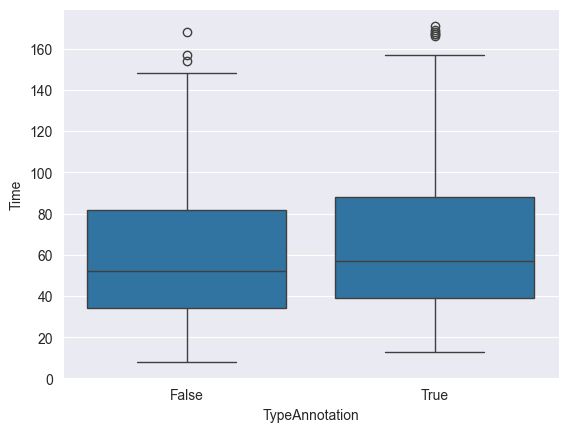

In [38]:
sns.boxplot(data=df_results_overall, y='Time', x='TypeAnnotation')
plt.show()

Do the same as above for the correctness

In [39]:
# percentage_TA = table.query("TypeAnnotation == True")["Correctness"]
# percentage_NoTA = table.query("TypeAnnotation == False")["Correctness"]

# please create a contingency table for CorrectAnswer on TypeAnnotation

contingency_table = pd.crosstab(df_results_overall['TypeAnnotation'], df_results_overall['CorrectAnswer'])
print(stats.chi2_contingency(contingency_table))
print(contingency_table)

try:
    data = compute_statistics(DataFrame(), df_results_overall.query("TypeAnnotation == True")["CorrectAnswer"], df_results_overall.query("TypeAnnotation == False")["CorrectAnswer"], input_type='categorical', output_type='categorical', population='within')
except:
    pass

print(df_results_overall.groupby('TypeAnnotation')['CorrectAnswer'].agg(['sum', 'count']))

Chi2ContingencyResult(statistic=np.float64(1.131155301120558), pvalue=np.float64(0.2875290452012436), dof=1, expected_freq=array([[ 37.94352159, 244.05647841],
       [ 43.05647841, 276.94352159]]))
CorrectAnswer   False  True 
TypeAnnotation              
False              33    249
True               48    272
At least one group is not normally distributed with pvalues 1.1565175355450153e-30 and 4.931277658399248e-30
Both groups have homogeneity of variance with pvalue 0.23741955584401728
                sum  count
TypeAnnotation            
False           249    282
True            272    320


#### Measures for RQ 1.2

First we should check for VerticalNext, VerticalLater, Regression, HorizontalLater, and LineRegression

But first let's create the table to analyze

In [40]:
list_measure: list[str] = ['VerticalNext', 'VerticalLater', 'Regression', 'HorizontalLater', 'LineRegression', 'StoryOrder_Naive_Score','StoryOrder_Dynamic_Score','StoryOrder_Dynamic_Repetitions', 'SaccadeLength']

table: DataFrame = df_results_overall.groupby(['Task', 'TypeAnnotation']).agg(table_data)
table.dropna(inplace=True)

In [41]:
for measure in list_measure:
    print(f'\nMeasure: {measure}')
    data = compute_statistics(table, df_results_overall.query("TypeAnnotation == True")[measure].dropna(), df_results_overall.query("TypeAnnotation == False")[measure].dropna(), input_type='categorical', output_type='continuous', population='within')


Measure: VerticalNext
At least one group is not normally distributed with pvalues 9.473891662441872e-06 and 9.459468186160426e-13
Both groups have homogeneity of variance with pvalue 0.6077771577604116
The U-statistic is 36061.5 and the p-value is 0.9174018407833775

Measure: VerticalLater
At least one group is not normally distributed with pvalues 0.007937314688451018 and 1.1941879135710278e-09
Both groups have homogeneity of variance with pvalue 0.6589971548069159
The U-statistic is 37357.5 and the p-value is 0.4086265418652908

Measure: Regression
At least one group is not normally distributed with pvalues 0.2706989986518649 and 0.029060707102578427
Both groups have homogeneity of variance with pvalue 0.24832408684035231
The U-statistic is 36348.0 and the p-value is 0.7922056208655495

Measure: HorizontalLater
At least one group is not normally distributed with pvalues 0.004790353316319475 and 1.1843264697904229e-05
Both groups have homogeneity of variance with pvalue 0.12802067075

#### Measures for RQ 1.3

This should include:

1. The difficulty for each of the snippets as giving by the people.
2. Did the Type Annotations help with the snippets?
3. Do Type Annotations help in general?

Do a likert scale analysis of the difficulty 

<Figure size 1000x600 with 0 Axes>

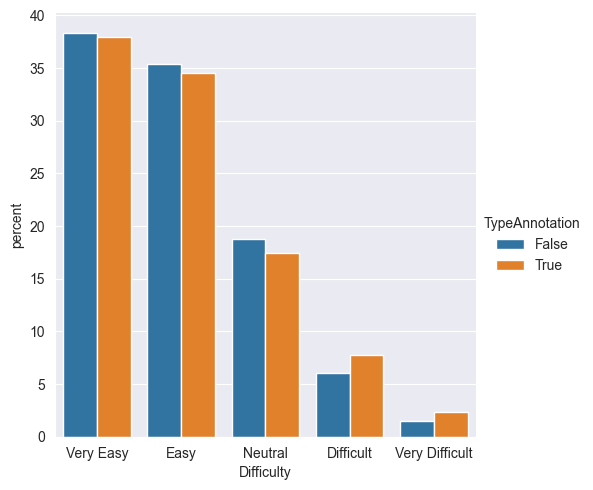

In [42]:
df1 = df_results_overall.groupby('TypeAnnotation')['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
            #legend=False,
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Type Annotation')
# plt.legend(title='Type Annotation', loc='upper right', labels=['Non-Annotated', 'Annotated'])
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/rq13difficultyLikertCatPlot.pdf', bbox_inches='tight')
plt.show()

And now with meaningful

    Meaningful  TypeAnnotation Difficulty    percent
10        True           False          2  37.681159
11        True           False          1  36.956522
12        True           False          3  18.115942
13        True           False          4   6.521739
14        True           False          5   0.724638
15        True            True          1  45.588235
16        True            True          2  36.764706
17        True            True          3  11.764706
18        True            True          4   5.147059
19        True            True          5   0.735294


<Figure size 1000x600 with 0 Axes>

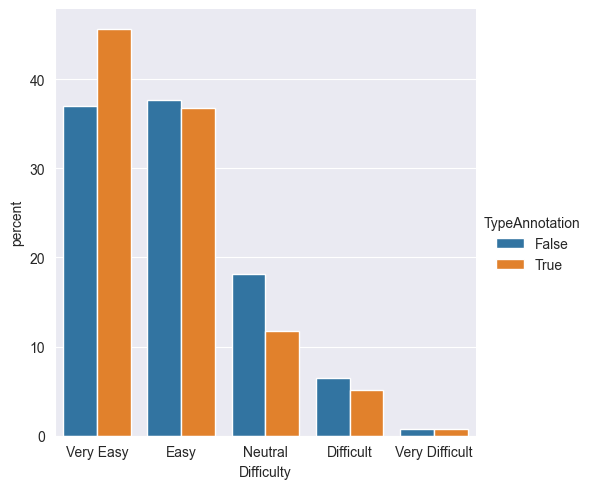

In [43]:
df1 = df_results_overall.groupby(['Meaningful', 'TypeAnnotation'])['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1[df1['Meaningful'] == True])

plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1[df1['Meaningful'] == True], 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Meaningful')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight', dpi=1200)
plt.show()

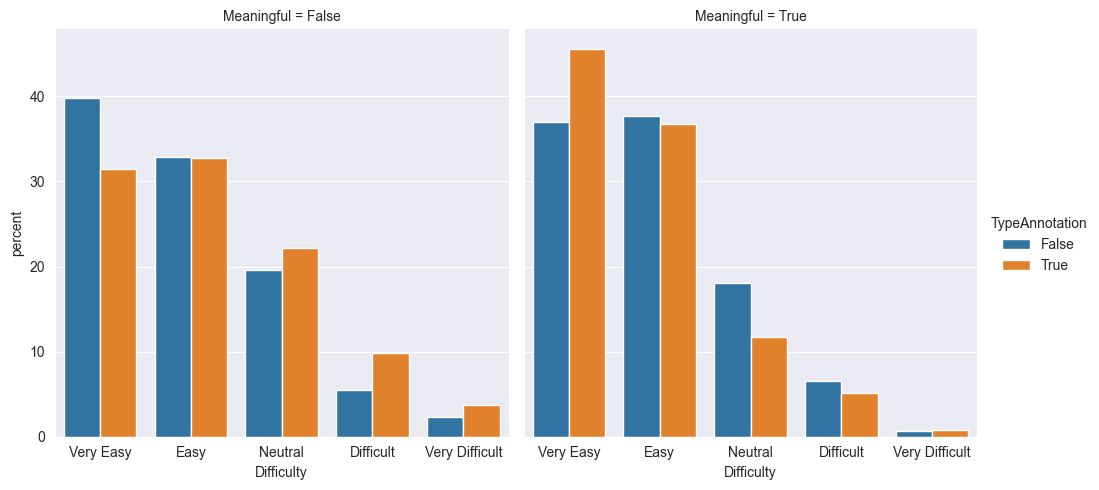

In [44]:
df1 = df_results_overall.groupby(['Meaningful', 'TypeAnnotation'])['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

# plt.figure(figsize=(10, 6))
# g = sns.FacetGrid(df1, col='Meaningful', hue='TypeAnnotation')
# g.map(sns.stripplot, 'Difficulty', 'percent', kind='bar')
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
            col='Meaningful',
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Meaningful')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotCombined.pdf', bbox_inches='tight', dpi=1200)
plt.show()

And now both?

<Figure size 1000x600 with 0 Axes>

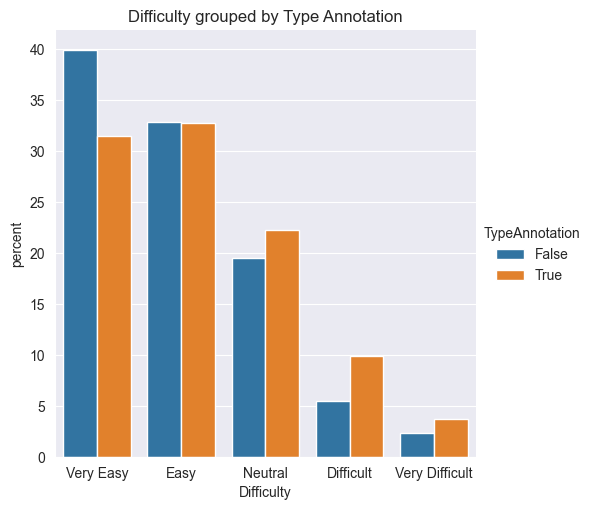

In [45]:
plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty', 
            hue='TypeAnnotation', 
            data=df1[df1['Meaningful'] == False], 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
plt.title('Difficulty grouped by Type Annotation')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotObfuscated.pdf', bbox_inches='tight')
plt.show()

Can we also find a statistical significance for this? using the chisquare test?

In [46]:
contingency_table = pd.crosstab(df_results_overall['TypeAnnotation'], df_results_overall['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(1.276271649293569), pvalue=np.float64(0.8653883427662029), dof=4, expected_freq=array([[101.40070922,  92.91134752,  48.10638298,  18.39361702,
          5.18794326],
       [113.59929078, 104.08865248,  53.89361702,  20.60638298,
          5.81205674]]))
Difficulty        1    2   3   4  5
TypeAnnotation                     
False           102   94  50  16  4
True            113  103  52  23  7


In [47]:
cont_df = df_results_overall[df_results_overall['Meaningful'] == True]
contingency_table = pd.crosstab(cont_df['TypeAnnotation'], cont_df['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(3.3212003137757566), pvalue=np.float64(0.5055802817298848), dof=4, expected_freq=array([[56.91240876, 51.37226277, 20.64963504,  8.05839416,  1.00729927],
       [56.08759124, 50.62773723, 20.35036496,  7.94160584,  0.99270073]]))
Difficulty       1   2   3  4  5
TypeAnnotation                  
False           51  52  25  9  1
True            62  50  16  7  1


In [48]:
cont_df = df_results_overall[df_results_overall['Meaningful'] == False]
contingency_table = pd.crosstab(cont_df['TypeAnnotation'], cont_df['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(3.845684009093344), pvalue=np.float64(0.42729289147715743), dof=4, expected_freq=array([[45.02068966, 41.93103448, 26.92413793, 10.15172414,  3.97241379],
       [56.97931034, 53.06896552, 34.07586207, 12.84827586,  5.02758621]]))
Difficulty       1   2   3   4  5
TypeAnnotation                   
False           51  42  25   7  3
True            51  53  36  16  6


In [49]:
contingency_table = pd.crosstab(df_results_overall['Meaningful'], df_results_overall['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(9.998191720961344), pvalue=np.float64(0.04045815323392401), dof=4, expected_freq=array([[110.54964539, 101.29432624,  52.44680851,  20.05319149,
          5.65602837],
       [104.45035461,  95.70567376,  49.55319149,  18.94680851,
          5.34397163]]))
Difficulty    1    2   3   4  5
Meaningful                     
False       102   95  61  23  9
True        113  102  41  16  2


How about some significance for the Comprehension within the study?

In [50]:
contingency_table = pd.crosstab(df_personal_information['TAComprehension'], df_personal_information['TAComprehensionGeneral'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(16.666666666666668), pvalue=np.float64(0.06006674082313683))
TAComprehensionGeneral  False  True 
TAComprehension                     
False                       2      3
True                        1     25


In [51]:
contingency_table = pd.crosstab(df_personal_information['TAComprehension'], df_personal_information['Meaningful'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(0.5714285714285714), pvalue=np.float64(0.6539364726239032))
Meaningful       False  True 
TAComprehension              
False                2      3
True                14     12


In [52]:
contingency_table = pd.crosstab(df_personal_information['TAComprehensionGeneral'], df_personal_information['Meaningful'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(2.0), pvalue=1.0)
Meaningful              False  True 
TAComprehensionGeneral              
False                       2      1
True                       14     14


Did the TA help with comprehension?

In [53]:
table_data: dict[str|list[str]] = {
    # 'Difficulty': ['mean'],
    'TAComprehension': [],
    # 'TAComprehensionGeneral': [],
}
print(df_personal_information.query('TAComprehension == False')['ID'])
df_personal_information['TAComprehension'].value_counts()

13    25574
33    60682
34    62039
37    74390
38    76211
Name: ID, dtype: object


TAComprehension
True     26
False     5
Name: count, dtype: int64

TA help with comprehension for Meaningful?

In [54]:
df_personal_information.groupby('Meaningful')['TAComprehension'].value_counts()

Meaningful  TAComprehension
False       True               14
            False               2
True        True               12
            False               3
Name: count, dtype: int64

In [55]:
stats.chisquare(df_personal_information.groupby('Meaningful')['TAComprehension'].value_counts())

Power_divergenceResult(statistic=np.float64(14.548387096774192), pvalue=np.float64(0.002246231047907265))

Do TA help in general?

In [56]:
print(df_personal_information.query('TAComprehensionGeneral == False')['ID'])

df_personal_information['TAComprehensionGeneral'].value_counts()

13    25574
18    33035
38    76211
Name: ID, dtype: object


TAComprehensionGeneral
True     28
False     3
Name: count, dtype: int64

In [57]:
df_personal_information.groupby('Meaningful')['TAComprehensionGeneral'].value_counts()

Meaningful  TAComprehensionGeneral
False       True                      14
            False                      2
True        True                      14
            False                      1
Name: count, dtype: int64

Create the plot for the difficulty of the snippets grouped by meaningful

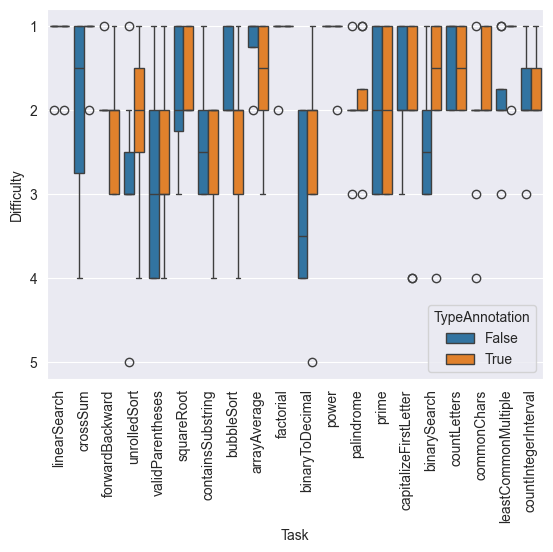

In [58]:
sns.boxplot(df_results_overall.query('Meaningful == True'), x='Task', y="Difficulty", hue="TypeAnnotation")
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 6, 1))
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/difficultyrq23_Meaningful.pdf', bbox_inches='tight')
plt.show()

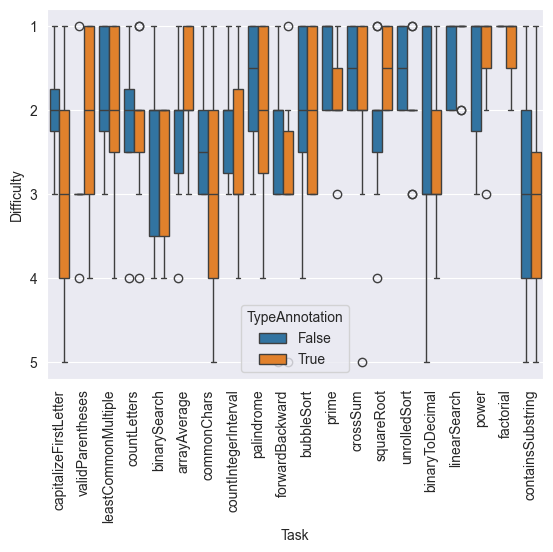

In [59]:
sns.boxplot(df_results_overall.query('Meaningful == False'), x='Task', y="Difficulty", hue="TypeAnnotation")
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 6, 1))
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/difficultyrq23_Obfuscated.pdf', bbox_inches='tight')
plt.show()

### Measures for RQ 2.1

This shall include all information for the bahavioral measures as seen above

In [60]:
table_data: dict[str, list[str]|str] = {
    'Time': ['mean', 'std'],
    # 'CorrectAnswer': ['sum', 'count'],
}

table: DataFrame = df_results_overall.groupby(['Task', 'TypeAnnotation', 'Meaningful']).agg(table_data)

# TA_L_mean = table.query("TypeAnnotation == True and Meaningful == False")["Time"]["mean"]
# NoTA_L_mean = table.query("TypeAnnotation == False and Meaningful == False")["Time"]["mean"]
# TA_M_mean = table.query('TypeAnnotation == True and Meaningful == True')['Time']['mean']
# NoTA_M_mean = table.query('TypeAnnotation == False and Meaningful == True')['Time']['mean']

TA_L = df_results_overall.query("TypeAnnotation == True and Meaningful == False")["Time"]
NoTA_L = df_results_overall.query("TypeAnnotation == False and Meaningful == False")["Time"]
TA_M = df_results_overall.query("TypeAnnotation == True and Meaningful == True")["Time"]
NoTA_M = df_results_overall.query("TypeAnnotation == False and Meaningful == True")["Time"]

print(f'NORMALITY:\n{pg.normality(df_results_overall, dv="Time", group="TypeAnnotation")}')
print(f'NORMALITY:\n{pg.normality(df_results_overall, dv="Time", group="Meaningful")}')


print(f'Levene:\n{stats.levene(TA_L, NoTA_M, TA_M, NoTA_L)}')

print(f'{df_results_overall.query("Time == 0")}')

# print(f'Obfuscated: Wilcoxon NoTA -> TA:\n{stats.wilcoxon(NoTA_L_mean, TA_L_mean)}')
# print(f'Obfuscated: MannWhitneyU NoTA -> Meaningful NoTA:\n{stats.mannwhitneyu(NoTA_L_mean, NoTA_M_mean)}')
# print(f'Obfuscated: MannWhitneyU NoTA -> Meaningful TA:\n{stats.mannwhitneyu(NoTA_L_mean, TA_M_mean)}')
# print(f'Obfuscated: MannWhitneyU TA -> Meaningful TA:\n{stats.mannwhitneyu(TA_L_mean, TA_M_mean)}')
# print(f'Meaningful: MannWhitneyU NoTA -> Obfuscated TA:\n{stats.mannwhitneyu(NoTA_M_mean, TA_L_mean)}')
# print(f'Meaningful: Wilcoxon NoTA -> TA:\n{stats.wilcoxon(NoTA_M_mean, TA_M_mean)}')
print(pg.sphericity(df_results_overall, dv='Time', within=['Meaningful'], subject='ID'))
print(pg.sphericity(df_results_overall, dv='Time', within=['TypeAnnotation'], subject='ID'))



print(pg.sphericity(df_results_overall, dv='CorrectAnswer', within=['Meaningful'], subject='ID'))
print(pg.sphericity(df_results_overall, dv='CorrectAnswer', within=['TypeAnnotation'], subject='ID'))
# print(pg.sphericity(df_results_overall, dv='Time', within=['TypeAnnotation', 'Meaningful'], subject='ID',))
# (df_results_overall[['Time', 'TypeAnnotation', 'Meaningful']].corr())#.sum(1).sort_values(ascending=False)
# print(stats.bartlett())



# piv = df_results_overall.pivot(index='ID', columns=['Meaningful', 'TypeAnnotation'], values='Time')
# piv.head()
# print(pg.sphericity(piv))


NORMALITY:
                       W          pval  normal
TypeAnnotation                                
True            0.938428  2.903718e-10   False
False           0.948809  2.332780e-08   False
NORMALITY:
                   W          pval  normal
Meaningful                                
True        0.933113  3.547659e-10   False
False       0.951257  1.215448e-08   False
Levene:
LeveneResult(statistic=np.float64(0.8124018929984512), pvalue=np.float64(0.48728454793770093))
Empty DataFrame
Columns: [ID, Number, Task, Answer_Out, Time, TimeOut, SubjectID, CorrectAnswer, Meaningful, TypeAnnotation, Participant, Expert, Snippet, Linearity, HasError, HitsBlock, HitsLine, HitsType, VerticalNext, VerticalLater, Regression, HorizontalLater, LineRegression, SaccadeLength, StoryOrder_Naive_Score, StoryOrder_Dynamic_Score, StoryOrder_Dynamic_Repetitions, ExecOrder_Naive_Score, ExecOrder_Dynamic_Score, ExecOrder_Dynamic_Repetitions, Difficulty, Comment]
Index: []

[0 rows x 32 columns]
(Tru

In [61]:
# use statsmodel to analyze the time with variables annotation and meaningful
model = smf.mixedlm('Time ~ TypeAnnotation * Meaningful', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())

                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           Time      
No. Observations:           602               Method:                       REML      
No. Groups:                 20                Scale:                        808.3923  
Min. group size:            26                Log-Likelihood:               -2887.0192
Max. group size:            31                Converged:                    Yes       
Mean group size:            30.1                                                      
--------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                  61.701    5.200 11.867 0.000  51.510 71.892
TypeAnnotation[T.True]                      5.836    3.324  1.756 0.

Check for contingency in CorrectAnswer

In [62]:
df_results_overall['CorrectAnswerNumeric'] = df_results_overall['CorrectAnswer'].apply(lambda x: 1 if x else 0)
model = smf.logit('CorrectAnswerNumeric ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

Optimization terminated successfully.
         Current function value: 0.392640
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     CorrectAnswerNumeric   No. Observations:                  602
Model:                            Logit   Df Residuals:                      598
Method:                             MLE   Df Model:                            3
Date:                  Mon, 15 Sep 2025   Pseudo R-squ.:                0.005844
Time:                          13:59:23   Log-Likelihood:                -236.37
converged:                         True   LL-Null:                       -237.76
Covariance Type:              nonrobust   LLR p-value:                    0.4270
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept         

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [63]:
model = smf.mixedlm('Time ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             Time      
No. Observations:             602                 Method:                         REML      
No. Groups:                   20                  Scale:                          808.3923  
Min. group size:              26                  Log-Likelihood:                 -2887.0192
Max. group size:              31                  Converged:                      Yes       
Mean group size:              30.1                                                          
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                        61.701    5.200 11.867 0.000  51.510 71.892
C(Mea

#### RQ 2.2 Linearity

In [64]:
list_measure: list[str] = ['VerticalNext', 
                           'VerticalLater', 'Regression', 'HorizontalLater', 'LineRegression', 'StoryOrder_Naive_Score','StoryOrder_Dynamic_Score','StoryOrder_Dynamic_Repetitions', 'SaccadeLength', 'Linearity'
                           ]

df_results_overall = df_results_overall[df_results_overall['LineRegression'].notna()].reset_index()
df_results_overall = df_results_overall[df_results_overall['SaccadeLength'].notna()].reset_index()

In [65]:
for measure in list_measure:
    print(f'\nMeasure: {measure}')
    if measure not in []:
        model = smf.mixedlm(f'{measure} ~ C(TypeAnnotation) * C(Meaningful)', data=df_results_overall, groups=df_results_overall['Task']).fit()
        print(model.summary())
    else:
        model = smf.mixedlm(f'{measure} ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
    print(model.wald_test_terms(scalar=True))


Measure: VerticalNext
                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           VerticalNext
No. Observations:             535               Method:                       REML        
No. Groups:                   20                Scale:                        0.0019      
Min. group size:              24                Log-Likelihood:               888.1543    
Max. group size:              29                Converged:                    Yes         
Mean group size:              26.8                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.131    0.005 26.259 0.000  0.121  0.141
C(T

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: C

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            Linearity 
No. Observations:             535                Method:                        REML      
No. Groups:                   20                 Scale:                         0.0000    
Min. group size:              24                 Log-Likelihood:                17968.0635
Max. group size:              29                 Converged:                     Yes       
Mean group size:              26.8                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        5.000                                    
C(TypeAnnotation)[T.True] 

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization faile

#### RQ 2.3

Check for the difficulty

In [66]:
# df_results_overall['DifficultyNumeric'] = df_results_overall['Difficulty'].apply(lambda x: 1 if x == 'Very Difficult' else  0)
df_results_overall['DifficultyNumeric'] = df_results_overall['Difficulty'].dropna().astype(float)
df_results_overall['DifficultyNumeric'] = df_results_overall['DifficultyNumeric'].apply(lambda x: x / 5)
model = smf.logit('DifficultyNumeric ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall, groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

Optimization terminated successfully.
         Current function value: 0.652216
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      DifficultyNumeric   No. Observations:                  497
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            3
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                 -0.1052
Time:                        13:59:24   Log-Likelihood:                -324.15
converged:                       True   LL-Null:                       -293.30
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                         

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


TAComprehension influenced by Meaningful?

63.598130841121495
35.476599824059825
7, 535


<Axes: ylabel='Time'>

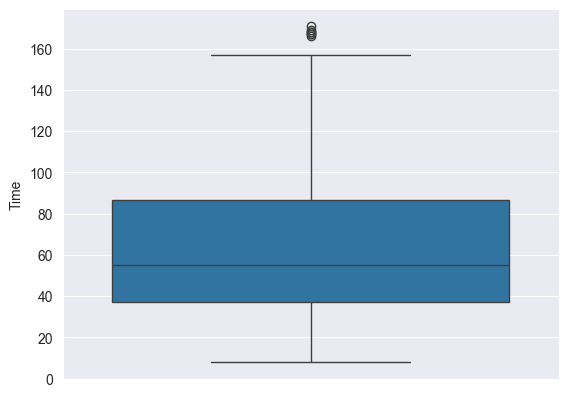

In [67]:
Q3 = df_results_overall.Time.quantile(0.75)
Q1 = df_results_overall.Time.quantile(0.25)
print(df_results_overall.Time.mean())
print(df_results_overall.Time.std())


IQR = Q3 - Q1
threshold = 1.5

outliers = df_results_overall[(df_results_overall['Time'] < Q1 - threshold * IQR) | (df_results_overall['Time'] > Q3 + threshold * IQR)]
print(f'{len(outliers.Time)}, {len(df_results_overall.Time)}')
sns.boxplot(df_results_overall, y='Time')

#### Miscellaneous

How did the people find themselves in comparison to others?

  Classmates    percent
0          3  41.935484
1          4  38.709677
2          2  12.903226
3          5   6.451613
4          1   0.000000


<Figure size 1000x600 with 0 Axes>

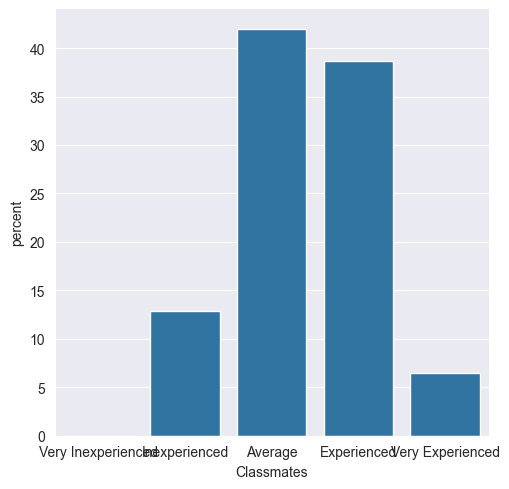

In [68]:
df1 = df_personal_information.Classmates.value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='Classmates', 
            # hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

For OverallExperience

  OverallExperience    percent
0                 3  48.387097
1                 4  41.935484
2                 2   9.677419
3                 1   0.000000
4                 5   0.000000


<Figure size 1000x600 with 0 Axes>

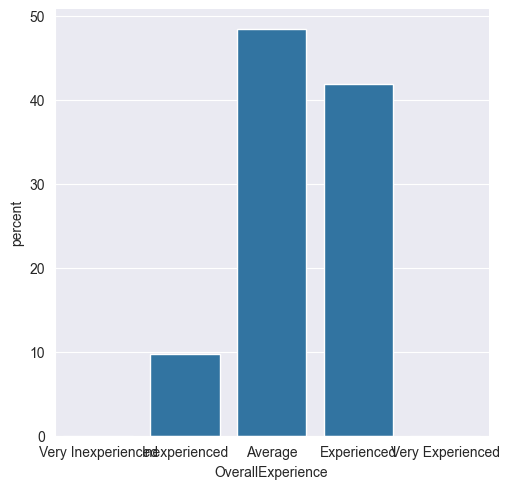

In [69]:
df1 = df_personal_information.OverallExperience.value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='OverallExperience', 
            # hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
)

plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

Years Programming

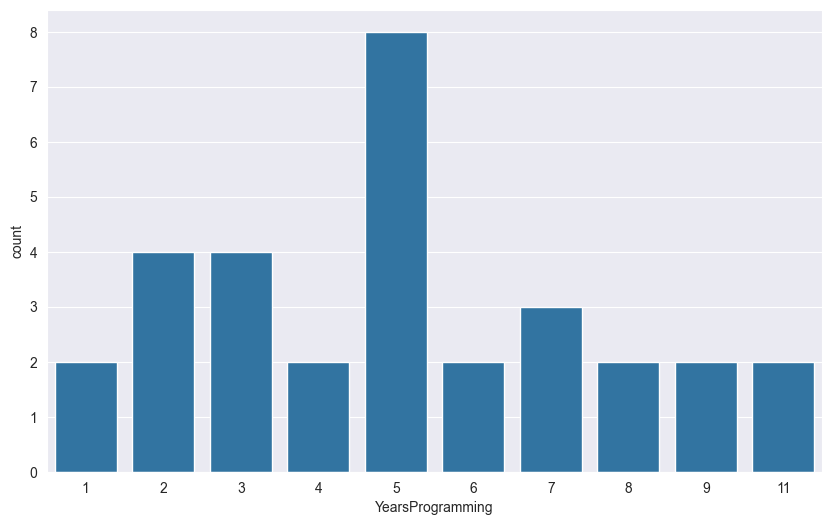

In [70]:
# df1 = df_personal_information.OverallExperience.value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('percent').reset_index()

# print(df1)

plt.figure(figsize=(10, 6))
sns.countplot(x='YearsProgramming',
            # hue='TypeAnnotation', 
            data=df_personal_information, 
            # kind='bar',
)

# plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

In [71]:
df_results_overall.Linearity.describe()

count    535.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%        5.0
max        5.0
Name: Linearity, dtype: float64

All Snippets with their mean and SD with correctness

In [72]:
df = df_results_overall.groupby(['Task', 'TypeAnnotation']).agg({'Time': ['mean', 'std']})
df

Time           
                                            mean        std
Task                  TypeAnnotation                       
arrayAverage          False            59.181818  29.314905
                      True             53.000000  20.850659
binarySearch          False            78.428571  35.094848
                      True             97.083333  33.987854
binaryToDecimal       False            78.000000  22.572107
                      True             66.714286  30.136685
bubbleSort            False            78.181818  41.279094
                      True             78.312500  29.443095
capitalizeFirstLetter False            79.700000  34.884094
                      True            100.833333  34.319005
commonChars           False            45.230769  21.221663
                      True             57.857143  30.394476
containsSubstring     False            78.000000  30.608641
                      True            103.000000  41.383226
countIntegerInterval  False            77.769231  29.026292
                      True             81.266667  18.831837
countLetters          False            37.000000  22.231734
                      True             65.466667  37.286280
crossSum              False            27.909091   9.944391
                      True             42.352941  16.120411
factorial             False            18.666667  10.184956
                      True             28.285714  19.930833
forwardBackward       False            74.307692  30.225223
                      True             70.400000  20.541943
leastCommonMultiple   False            65.538462  23.204222
                      True             41.923077  18.940528
linearSearch          False            27.500000  11.088032
                      True             30.058824  12.676112
palindrome            False            70.900000  41.908498
                      True             66.250000  35.564964
power                 False            34.500000  12.369317
                      True             40.333333  12.573593
prime                 False            52.200000  19.098242
                      True             72.071429  48.593232
squareRoot            False            74.687500  24.151518
                      True             52.333333  22.561028
unrolledSort          False            51.916667  28.256804
                      True             68.000000  31.176915
validParentheses      False           102.500000  25.720526
                      True            102.133333  43.286201

## Currently unnecessary and unused data

   TypeAnnotation  Meaningful  CorrectAnswer    percent
0           False       False           True  87.500000
1           False       False          False  12.500000
2           False        True           True  88.429752
3           False        True          False  11.570248
4            True       False           True  83.125000
5            True       False          False  16.875000
6            True        True           True  85.714286
7            True        True          False  14.285714


<Figure size 1000x600 with 0 Axes>

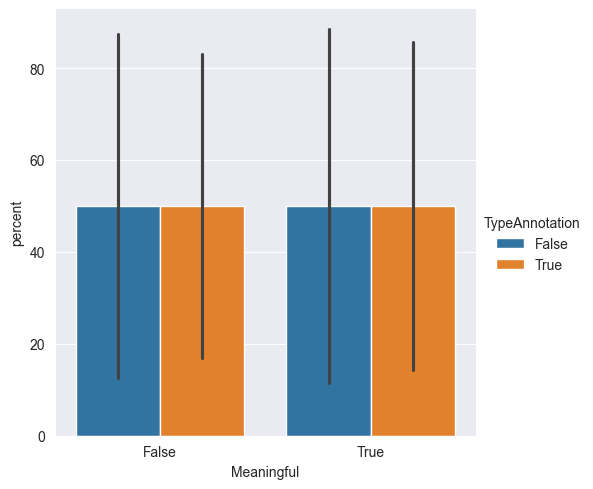

In [73]:
df1 = df_results_overall.groupby(['TypeAnnotation', 'Meaningful'])['CorrectAnswer'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='Meaningful', 
            hue='TypeAnnotation', 
            data=df1, 
            kind='bar',
            y='percent',
)
plt.show()

#### Table for Type Annotations and Meaningful

In [74]:
table_data: dict[str, list[str]|str] = {
    'Time': ['mean', 'std'],
    'CorrectAnswer': ['sum', 'count'],
}

df_results_overall.groupby(['Task', 'Meaningful', 'TypeAnnotation']).agg(table_data)

Time             \
                                                  mean        std   
Task             Meaningful TypeAnnotation                          
arrayAverage     False      False            70.714286  31.388503   
                            True             61.444444  18.000772   
                 True       False            39.000000   6.377042   
                            True             43.500000  20.701967   
binarySearch     False      False            91.285714  45.231679   
...                                                ...        ...   
unrolledSort     True       True             68.000000  27.633313   
validParentheses False      False            96.166667  15.778678   
                            True             86.125000  46.850637   
                 True       False           108.833333  33.319164   
                            True            120.428571  32.847411   

                                           CorrectAnswer        
                                                     sum count  
Task             Meaningful TypeAnnotation                      
arrayAverage     False      False                      6     7  
                            True                       9     9  
                 True       False                      4     4  
                            True                       8     8  
binarySearch     False      False                      6     7  
...                                                  ...   ...  
unrolledSort     True       True                       4     6  
validParentheses False      False                      5     6  
                            True                       8     8  
                 True       False                      6     6  
                            True                       4     7  

[80 rows x 4 columns]

### Task Plots

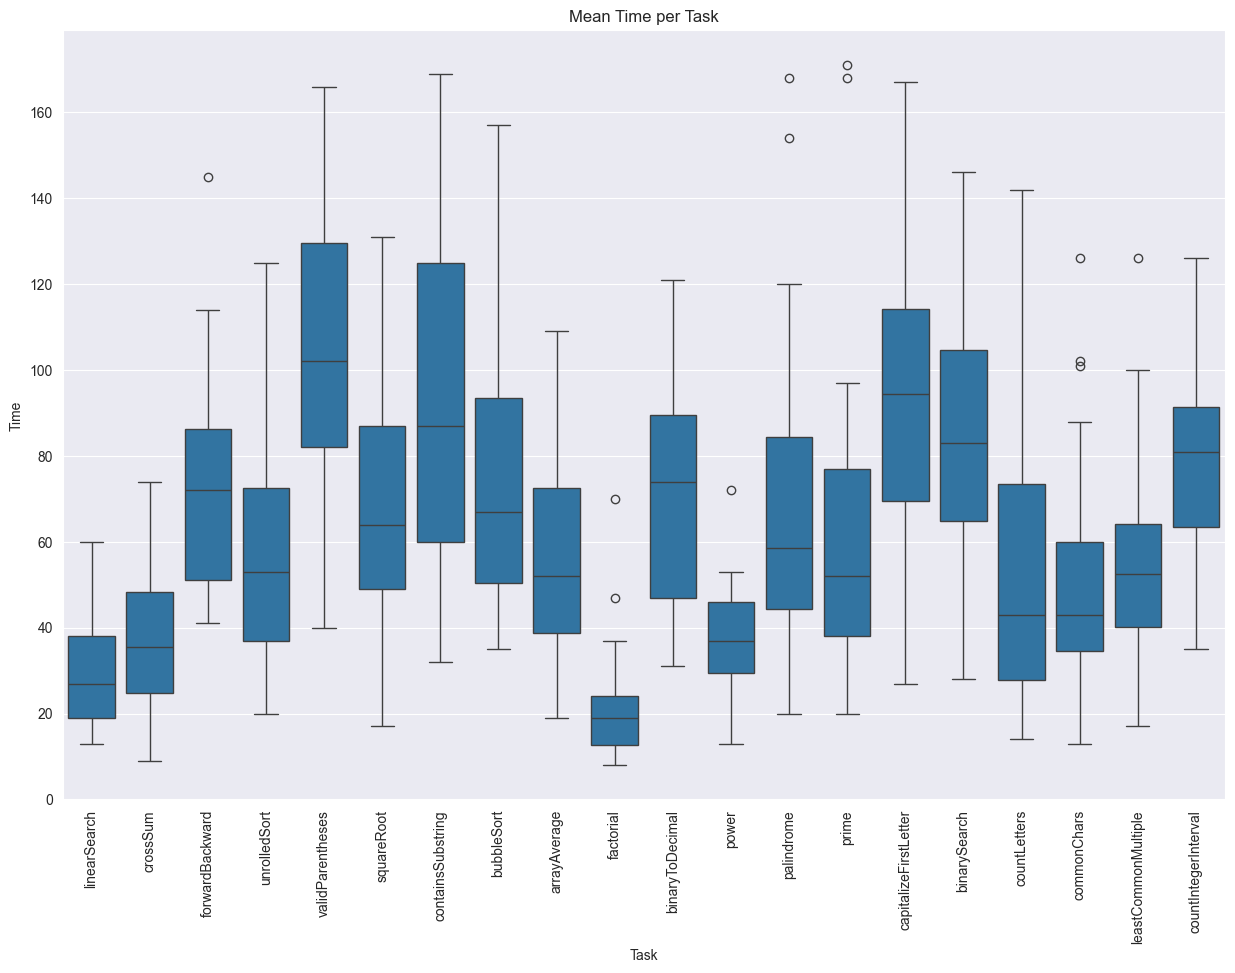

In [75]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot for the mean length of each task
plt.figure(figsize=(15, 10))
sns.boxplot(x='Task', y='Time', data=df_results_overall)
plt.title('Mean Time per Task')
plt.xticks(rotation=90)
plt.show()

The mean time per task by Type Annotation

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/637111080.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True')['Time'] for task in all_tasks], labels=all_tasks,)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/637111080.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False')['Time'] for task in all_tasks], labels=all_tasks,)


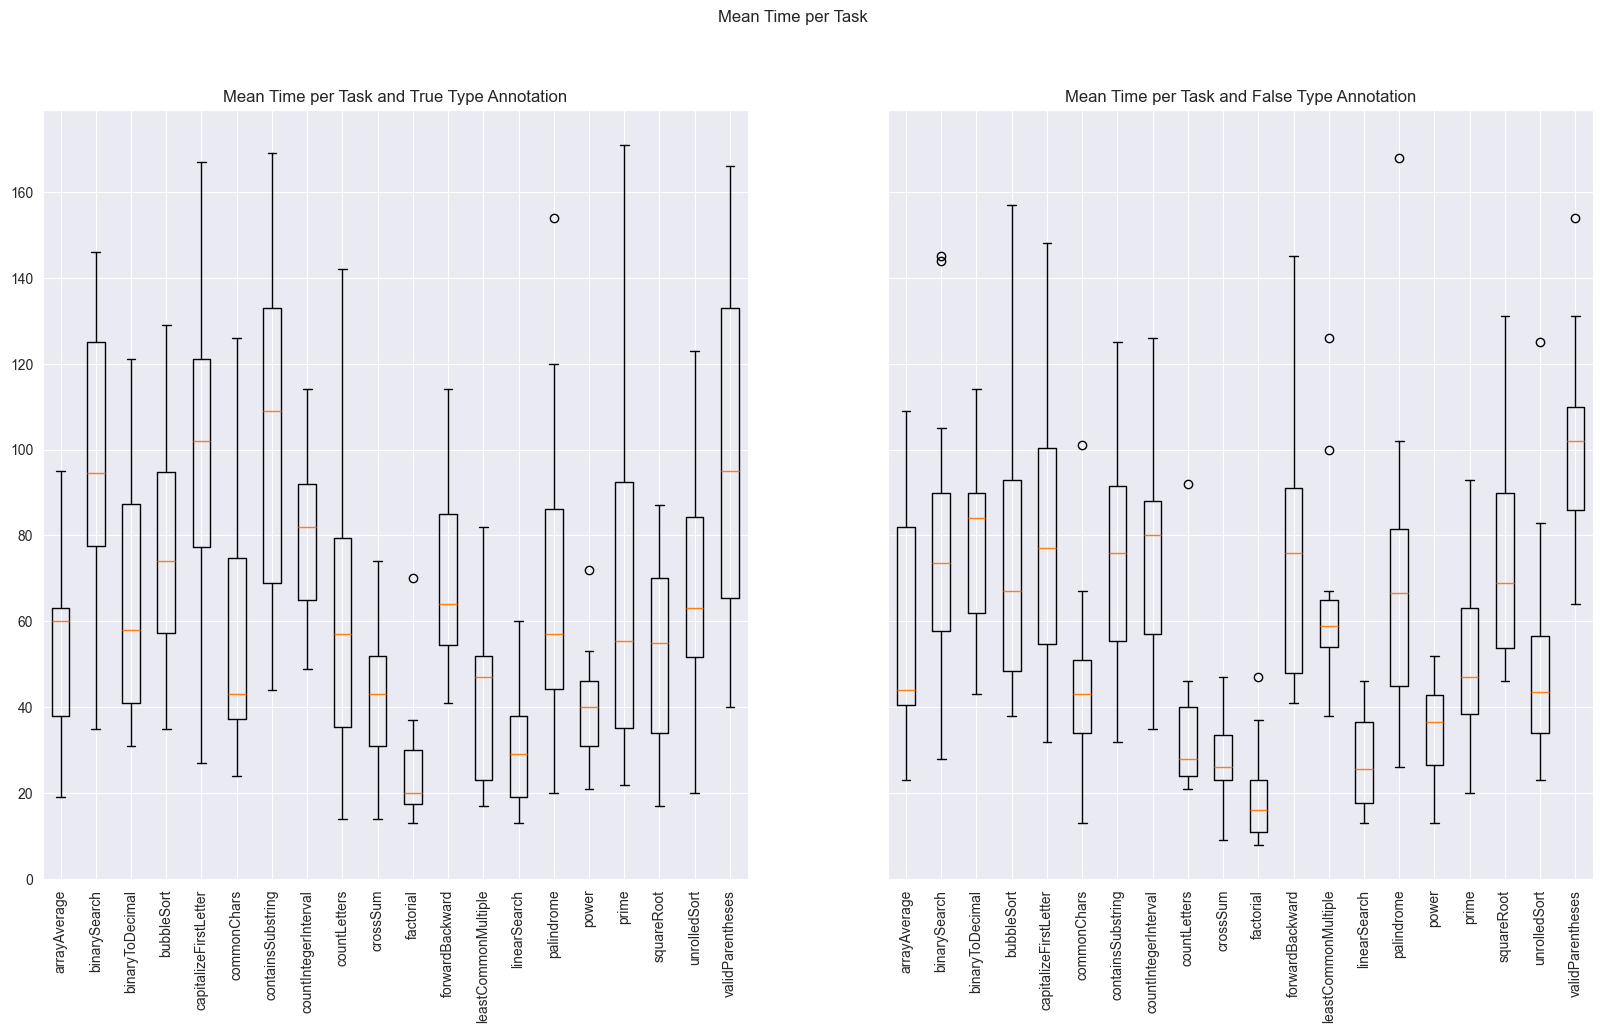

In [76]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True')['Time'] for task in all_tasks], labels=all_tasks,)
axs[0].set_xticklabels(all_tasks, rotation=90)
axs[0].set_title('Mean Time per Task and True Type Annotation')


axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1].set_xticklabels(all_tasks, rotation=90)
axs[1].set_title('Mean Time per Task and False Type Annotation')

plt.show()

The mean time per task by Identifier Name

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1276528124.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1276528124.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)


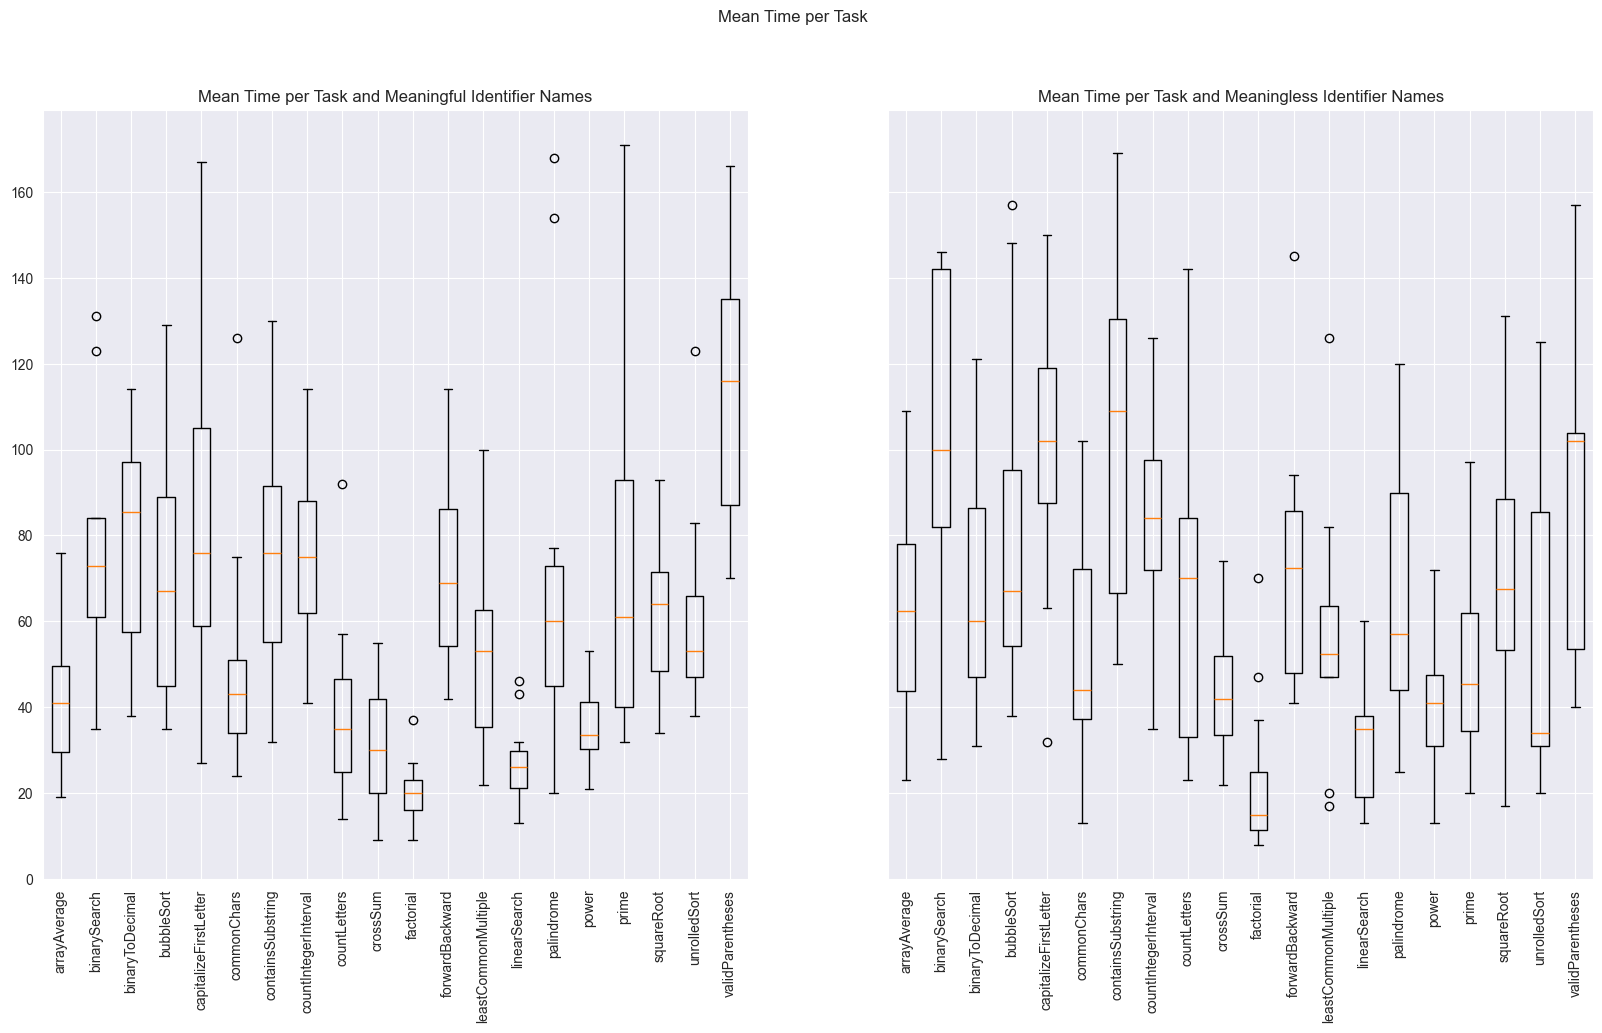

In [77]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
axs[0].set_xticklabels(all_tasks, rotation=90)
axs[0].set_title('Mean Time per Task and Meaningful Identifier Names')


axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1].set_xticklabels(all_tasks, rotation=90)
axs[1].set_title('Mean Time per Task and Meaningless Identifier Names')

plt.show()

The mean time per task and for the combinations of Type Annoations and Identifier Names

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/123170642.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks, notch=False)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/123170642.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/123170642.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplo

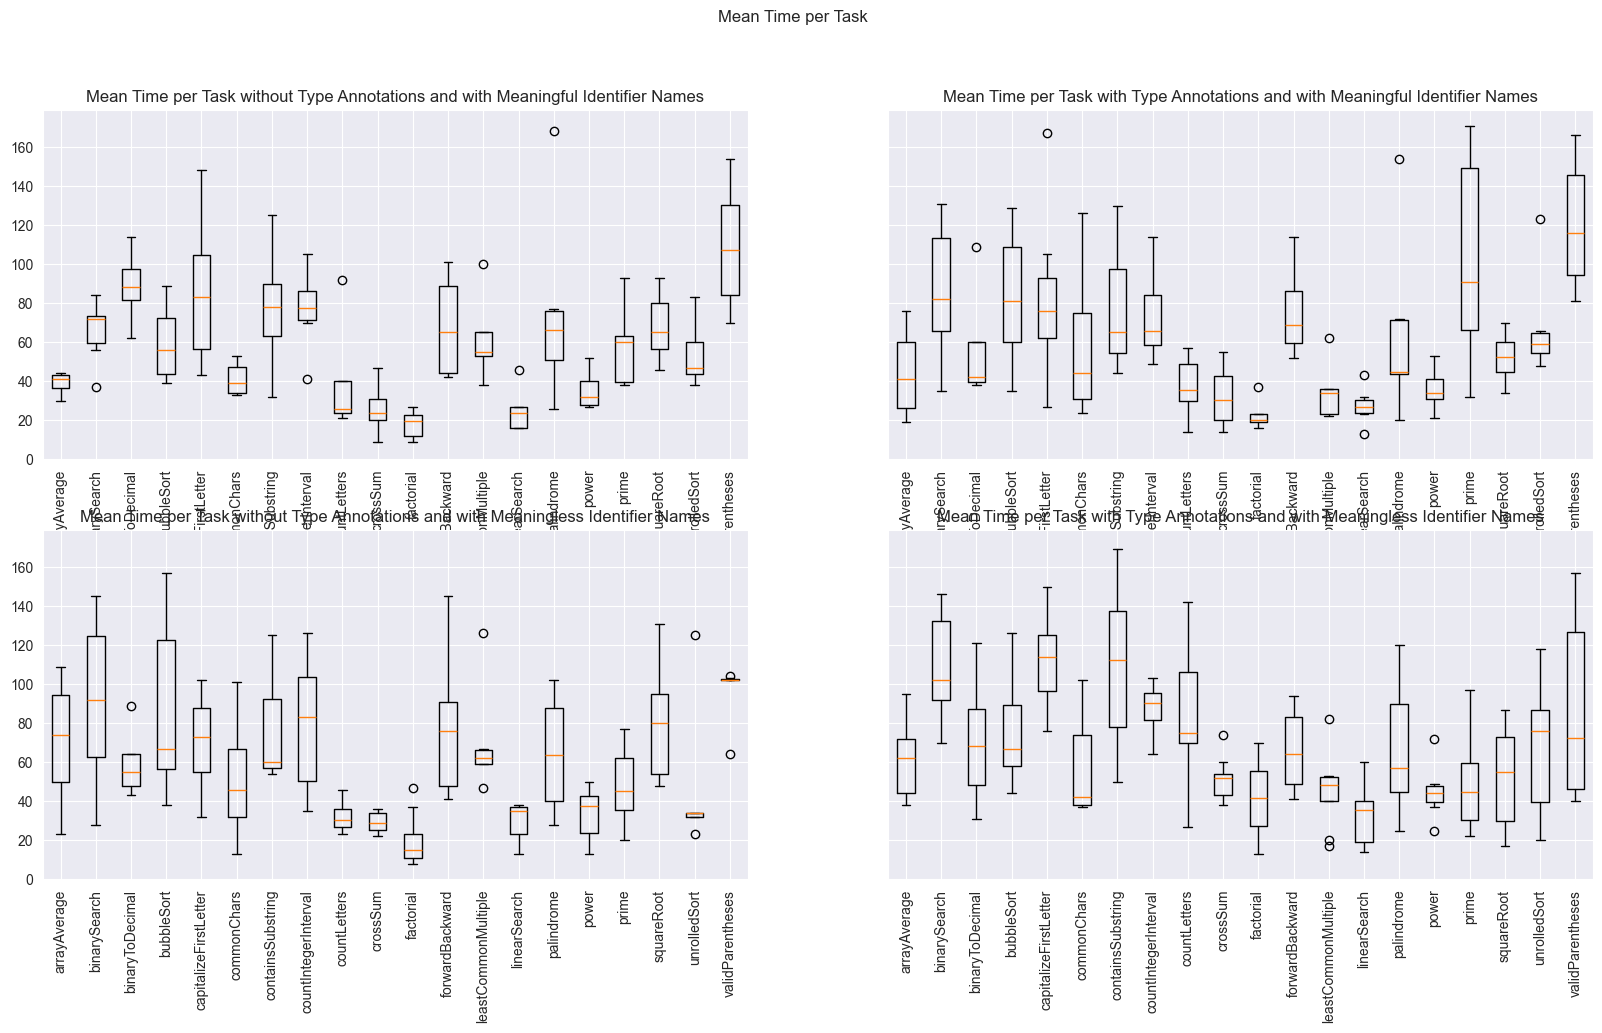

In [78]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0, 0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks, notch=False)
axs[0, 0].set_xticklabels(all_tasks, rotation=90)
axs[0, 0].set_title('Mean Time per Task without Type Annotations and with Meaningful Identifier Names')

axs[0, 1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for task in all_tasks], labels=all_tasks,)
axs[0, 1].set_xticklabels(all_tasks, rotation=90)
axs[0, 1].set_title('Mean Time per Task with Type Annotations and with Meaningful Identifier Names')

axs[1, 0].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1, 0].set_xticklabels(all_tasks, rotation=90)
axs[1, 0].set_title('Mean Time per Task without Type Annotations and with Meaningless Identifier Names')

axs[1, 1].boxplot(x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == False')['Time'] for task in all_tasks], labels=all_tasks,)
axs[1, 1].set_xticklabels(all_tasks, rotation=90)
axs[1, 1].set_title('Mean Time per Task with Type Annotations and with Meaningless Identifier Names')

plt.show()

A plot to describe how long each task took overall and how this is distributed among the participants.

A plot that shows how long each participant took grouped by task.

Combine the Type Annotation plots in the top row into one bigger plot with comparison.

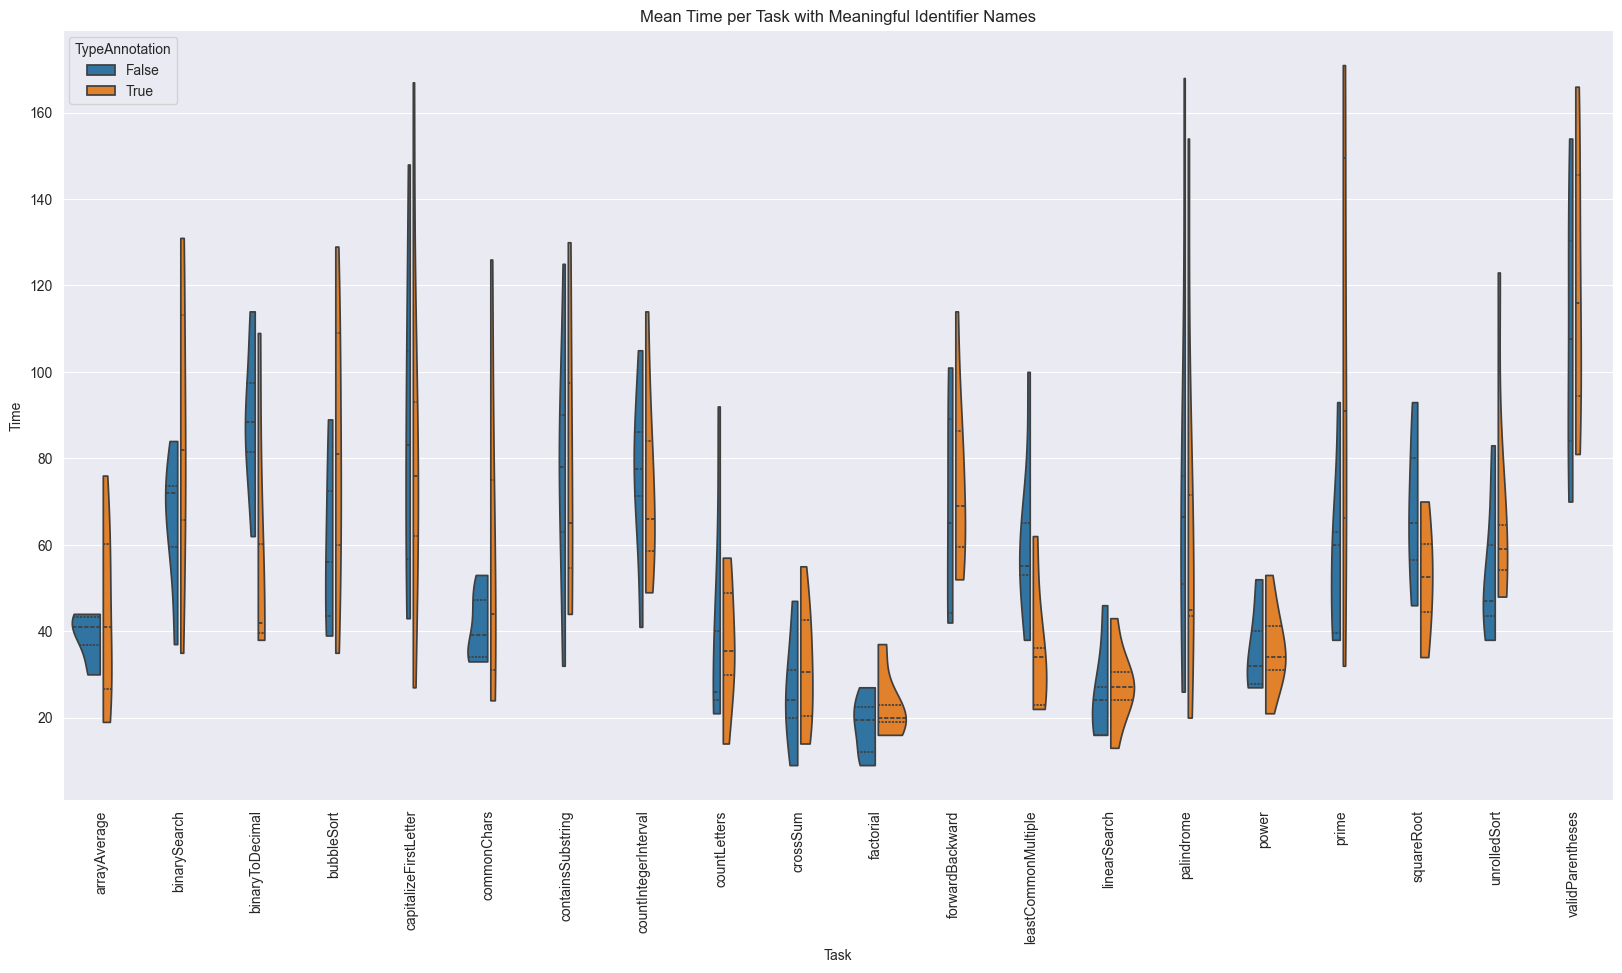

In [79]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == True'), x='Task', y='Time', hue='TypeAnnotation', split=True, gap=.1, inner="quart", cut=0, order=all_tasks)

plt.xticks(all_tasks, rotation=90)
plt.title('Mean Time per Task with Meaningful Identifier Names')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/timePerTaskrq21_meaningful.pdf', bbox_inches='tight')

plt.show()

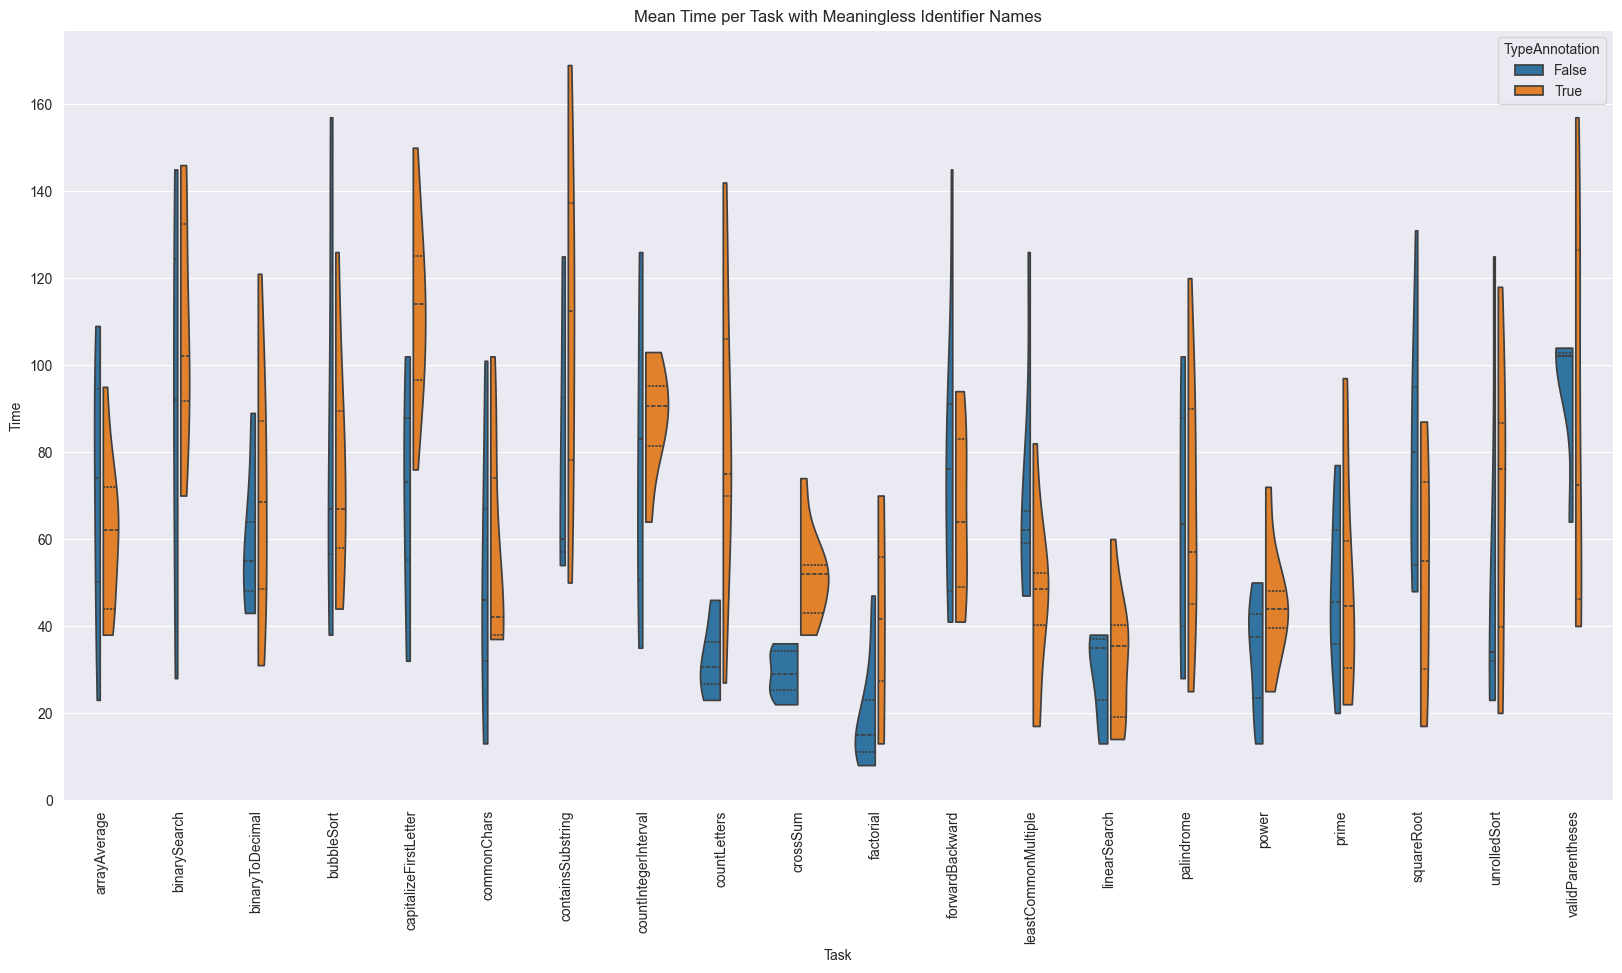

In [80]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == False'), x='Task', y='Time', hue='TypeAnnotation', split=True, gap=.1, inner="quart", cut=0, order=all_tasks)

plt.xticks(all_tasks, rotation=90)
plt.title('Mean Time per Task with Meaningless Identifier Names') 

# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/timePerTaskrq21_obfuscated.pdf', bbox_inches='tight')
plt.show()

What were the Means and the Standard Deviation for meaningful and type annotation?

In [81]:
print(df_results_overall.groupby(['Meaningful', 'TypeAnnotation', ]).agg({'Time': ['mean', 'std']}))
print(df_results_overall.groupby(['Meaningful']).agg({'Time': ['mean', 'std']}))


                                Time           
                                mean        std
Meaningful TypeAnnotation                      
False      False           59.812500  35.792215
           True            70.856250  35.193240
True       False           59.685950  31.750599
           True            61.984127  37.846212
                 Time           
                 mean        std
Meaningful                      
False       65.947917  35.822939
True        60.858300  34.941300


As for the correctness:

In [82]:
print(df_results_overall.groupby(['Meaningful', 'TypeAnnotation', ]).agg({'CorrectAnswer': ['sum', 'count']}))
print(df_results_overall.groupby(['Meaningful']).agg({'CorrectAnswer': ['sum', 'count']}))
print(df_results_overall.groupby(['TypeAnnotation']).agg({'CorrectAnswer': ['sum', 'count']}))

                          CorrectAnswer      
                                    sum count
Meaningful TypeAnnotation                    
False      False                    112   128
           True                     133   160
True       False                    107   121
           True                     108   126
           CorrectAnswer      
                     sum count
Meaningful                    
False                245   288
True                 215   247
               CorrectAnswer      
                         sum count
TypeAnnotation                    
False                    219   249
True                     241   286


Correlation heatmap and p-values for the time

P-Values:
        M-TA     L-N    L-TA     M-N
L-N   0.0005     0.0  0.0042     0.0
L-TA  0.0042  0.0042     0.0  0.0023
M-N   0.0001     0.0  0.0023     0.0
M-TA     0.0  0.0005  0.0042  0.0001


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/307995445.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)


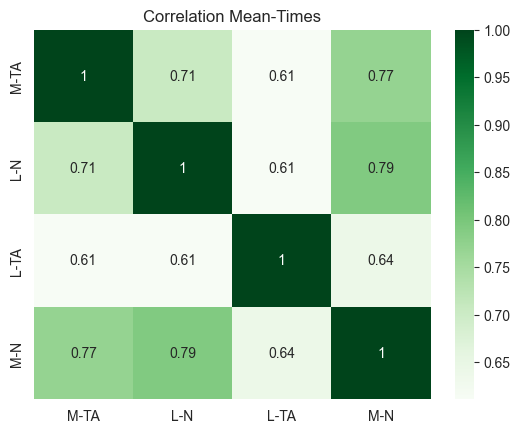

In [83]:
df_correlation_meantimes_snippets: DataFrame = DataFrame()

df_correlation_meantimes_snippets['M-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg({'Time': 'mean'})['Time']
df_correlation_meantimes_snippets['L-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg({'Time': 'mean'})['Time']
df_correlation_meantimes_snippets['L-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg({'Time': 'mean'})['Time']
df_correlation_meantimes_snippets['M-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg({'Time': 'mean'})['Time']

matrix = df_correlation_meantimes_snippets.corr()
print(f'P-Values:\n{calculate_pvalues(df_correlation_meantimes_snippets)}')

sns.heatmap(matrix, cmap="Greens", annot=True)
plt.title(f'Correlation Mean-Times')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/correlation_meantimesrq21.pdf', bbox_inches='tight')
plt.show()

Correlation and p-values for the correctness

P-Values:
       M-TA     L-N    L-TA     M-N
L-N   0.352     0.0  0.2199  0.9715
L-TA   0.48  0.2199     0.0  0.4157
M-N   0.264  0.9715  0.4157     0.0
M-TA    0.0   0.352    0.48   0.264


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/307995445.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)


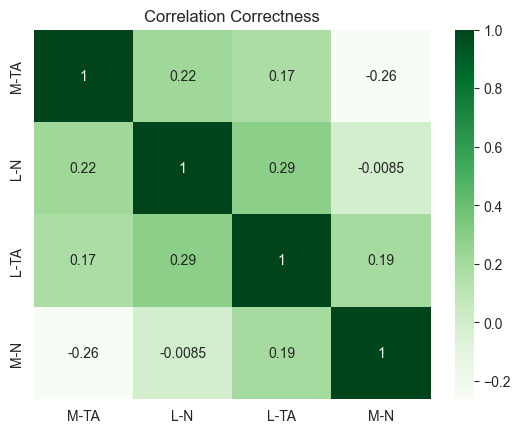

In [84]:
df_correlation_correctness_snippets: DataFrame = DataFrame()

df_correlation_correctness_snippets['M-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['L-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['L-TA'] = df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['M-N'] = df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'sum'})['CorrectAnswer'] / df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg({'CorrectAnswer': 'count'})['CorrectAnswer']

matrix = df_correlation_correctness_snippets.corr()
print(f'P-Values:\n{calculate_pvalues(df_correlation_correctness_snippets)}')

sns.heatmap(matrix, cmap="Greens", annot=True)
plt.title(f'Correlation Correctness')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/correlation_correctnessrq21.pdf', bbox_inches='tight')
plt.show()

Show the mean time with and without type annotations for each participant.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/2084840597.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/2084840597.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_pa

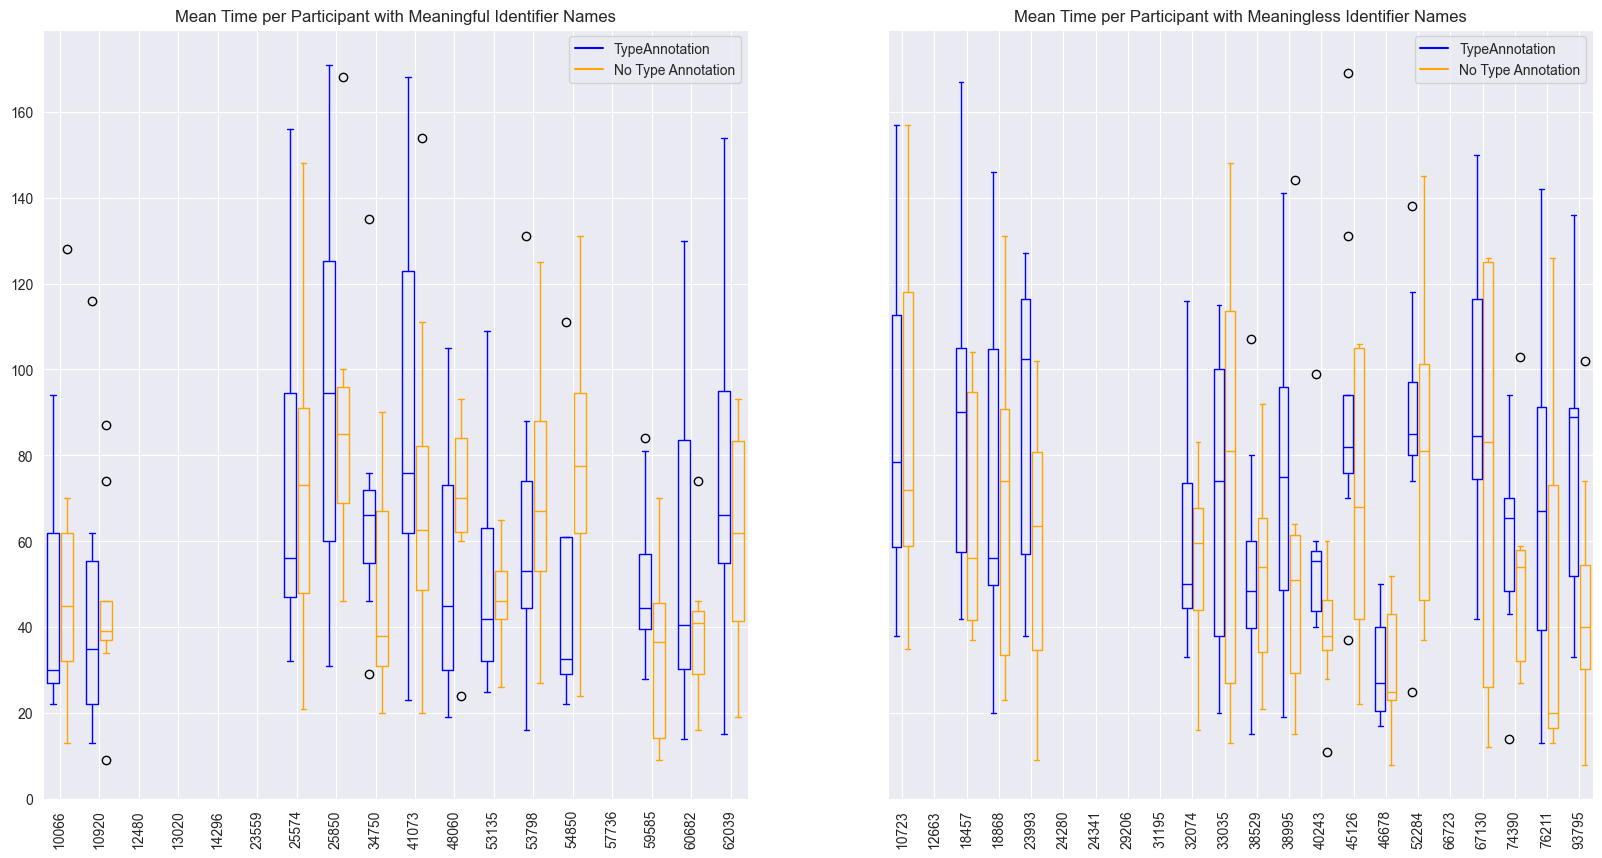

In [85]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), sharey=True)

# first plot
plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0-0.35, widths=0.6)

# first plot settings
axs[0].set_title('Mean Time per Participant with Meaningful Identifier Names')
axs[0].set_xticks(np.arange(0, len(meaningful_participants) * 2, 2), meaningful_participants, rotation=90)
define_box_properties(plot_TA_M, 'blue', 'TypeAnnotation', axs[0])
define_box_properties(plot_L_M, 'orange', 'No Type Annotation', axs[0])

# second plot
plot_L_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == False')['Time'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0+0.35, widths=0.6)
plot_TA_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == False')['Time'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0-0.35, widths=0.6)

# second plot settings
axs[1].set_title('Mean Time per Participant with Meaningless Identifier Names')
axs[1].set_xticks(np.arange(0, len(meaningless_participants) * 2, 2), meaningless_participants, rotation=90)
define_box_properties(plot_TA_L, 'blue', 'TypeAnnotation', axs[1])
define_box_properties(plot_L_L, 'orange', 'No Type Annotation', axs[1])

plt.show()


How long people took overall.

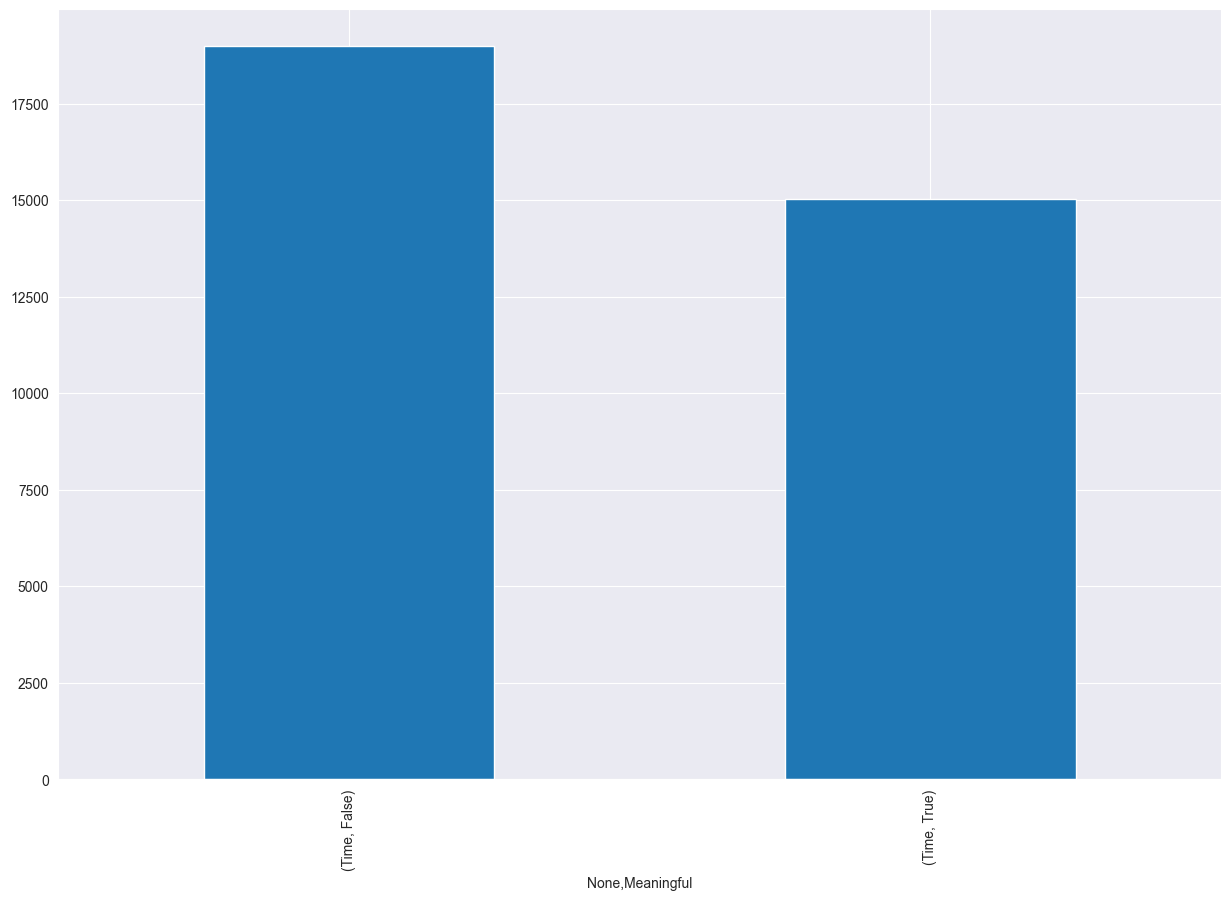

In [86]:
df_results_overall.groupby(['Meaningful',]).agg({'Time': 'sum'}).unstack().T.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.show()

Do `meaningful` snippets make participants faster on average?

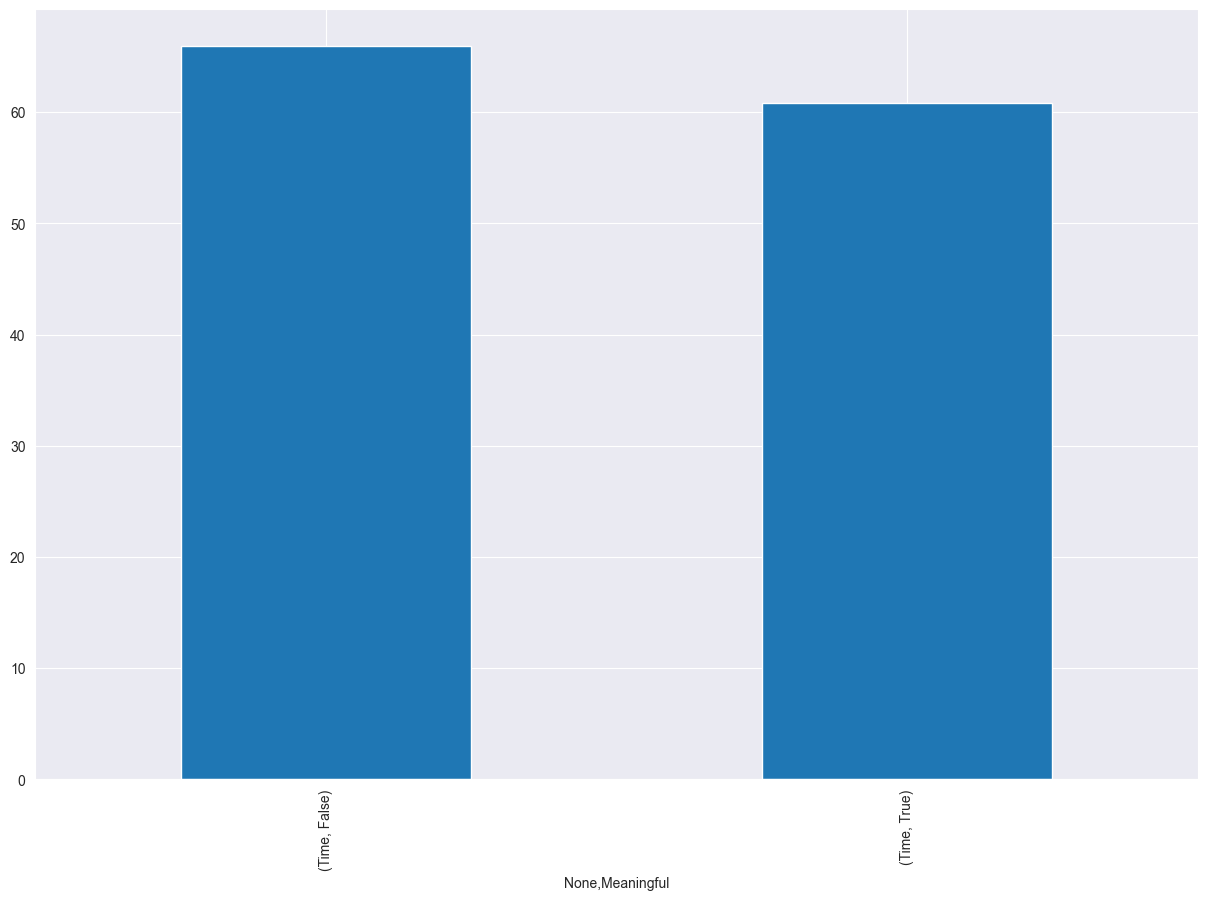

In [87]:
# compute if meaningful snippets were faster on average than meaningless snippets
df_results_overall.groupby(['Meaningful']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', stacked=False, figsize=(15, 10))
plt.show()

Do `Type Annotations` make people faster on average?

- [ ] TODO: Apparently, this is not the case. Why could this be? More to read? Where do people look during this time? What are they focusing on? Are they more correct?

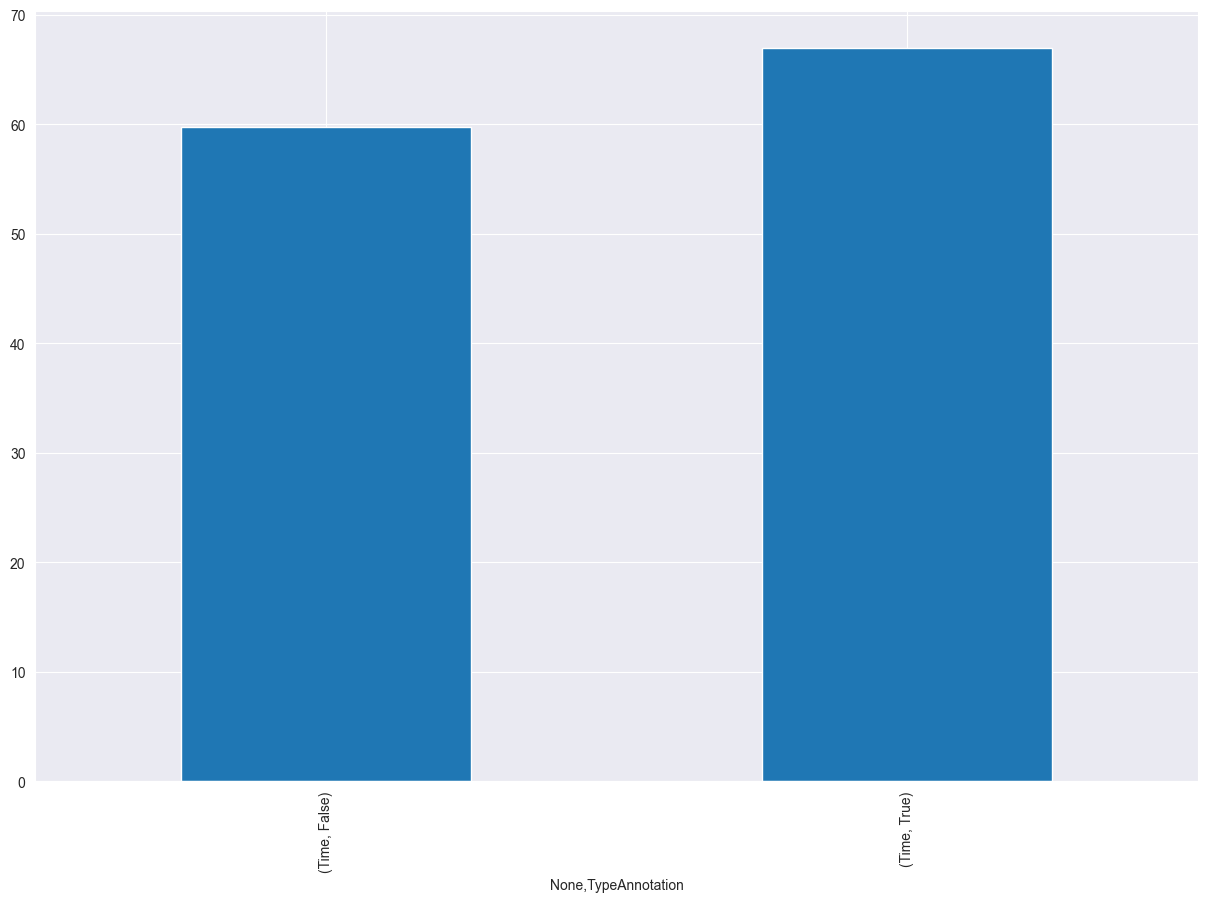

In [88]:
# compute if type annotated snippets were faster on average than non type annotated snippets
df_results_overall.groupby(['TypeAnnotation']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.show()

Do `Type Annotations` make people faster when we differentiate between `Meaningful` snippets?

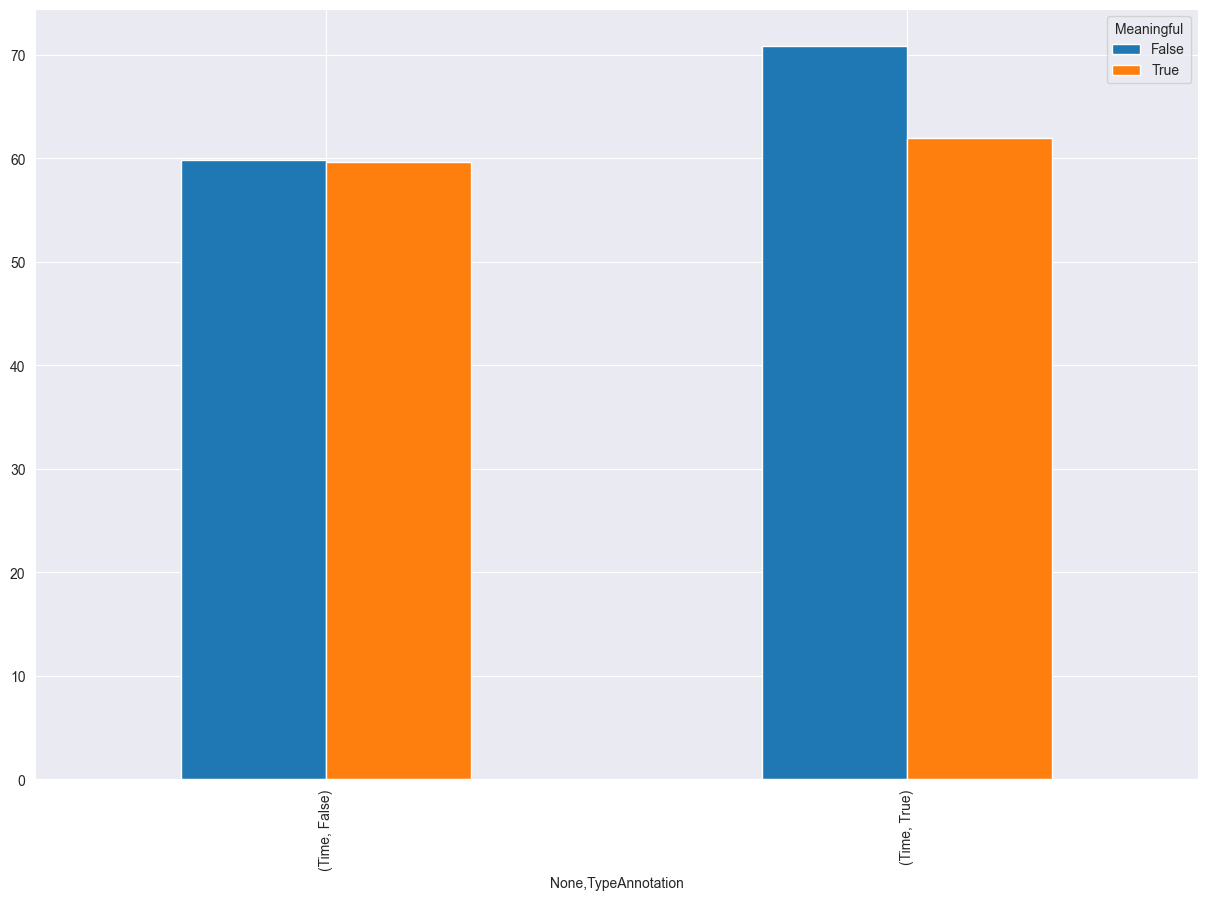

In [89]:
df_results_overall.groupby(['Meaningful', 'TypeAnnotation']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10))
plt.show()

Are snippets with `Type Annotations` more correct?

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1592773364.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[0], color='orange', linestyle='--', label='Max False') # False
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1592773364.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[1], color='green', linestyle='--', label='Max True') # True
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/15927733

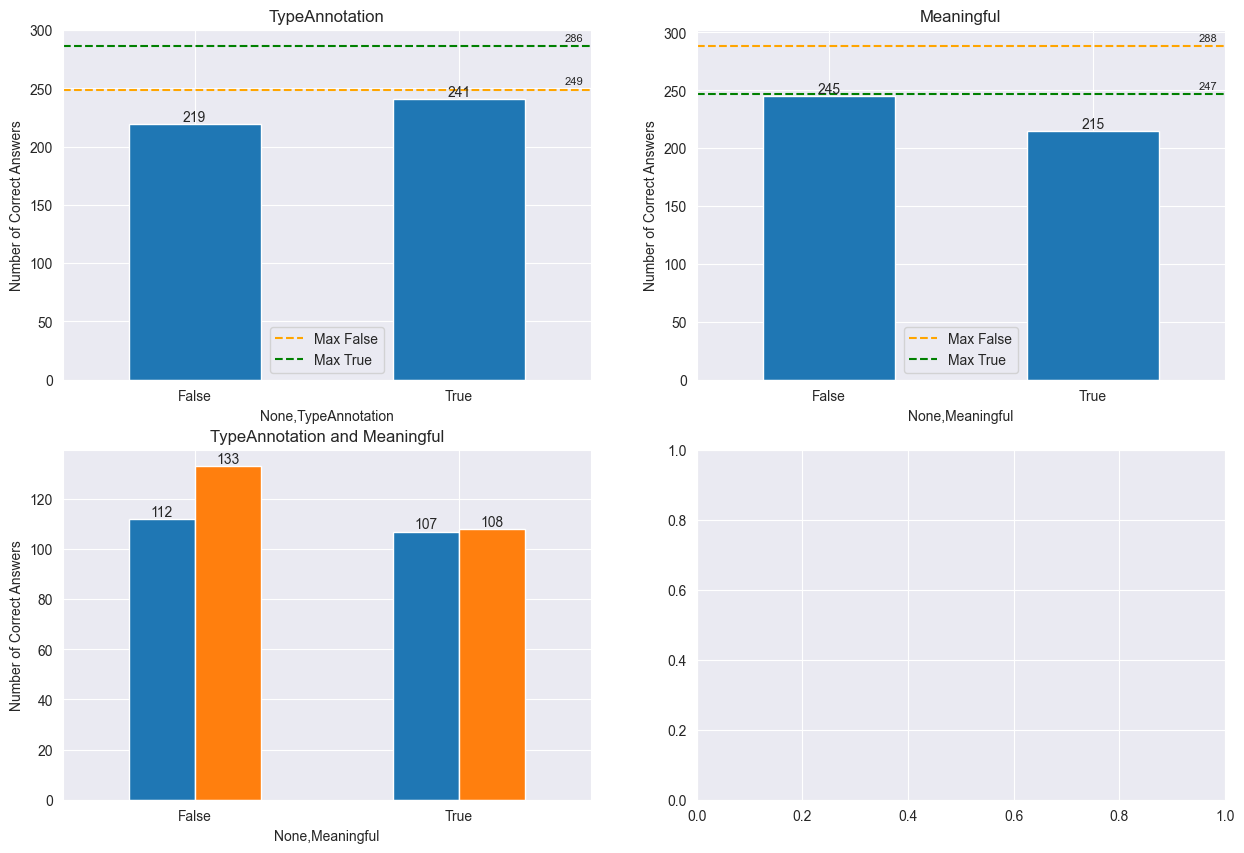

In [90]:
snippets_grouping: list[str|list[str]] = ['TypeAnnotation', 'Meaningful',  ['TypeAnnotation', 'Meaningful'],]

# create a plot consisting of len(snippets_grouping) subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, x in enumerate(snippets_grouping):
    ax = df_results_overall.groupby(x).agg({'CorrectAnswer': np.count_nonzero}).unstack().T.plot(kind='bar', ax=axs[i // 2, i % 2], title=(lambda x: f'{x[0]} and {x[1]}' if len(x) == 2 else x)(x), ylabel='Number of Correct Answers', legend=False)

    ax.set_xticklabels(['False', 'True'], rotation=0)

    if len(x) != 2:
        ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[0], color='orange', linestyle='--', label='Max False') # False
        ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[1], color='green', linestyle='--', label='Max True') # True
        ax.legend(loc='lower center')
    
    for line in ax.lines:
        ax.annotate(str(int(line.get_ydata()[0])), xy=(line.get_xdata()[0], line.get_ydata()[0]), xytext=(280, 2), textcoords='offset points', ha='right', va='bottom', fontsize=8)

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

Are snippets that are `Meaningful` more correct?

In [91]:
df_results_overall.groupby(['TypeAnnotation', 'Meaningful']).agg({'CorrectAnswer': 'count'}).unstack()

CorrectAnswer      
Meaningful             False True 
TypeAnnotation                    
False                    128   121
True                     160   126

A better representation of this:

In [92]:
correct_TA_M: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].sum()
correct_TA_L: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].sum()
correct_L_M: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].sum()
correct_L_L: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].sum()

total_TA_M: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].count()
total_TA_L: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].count()
total_L_M: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].count()
total_L_L: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].count()

print(f'Type Annotation and Meaningful: {correct_TA_M}/{total_TA_M} = {correct_TA_M / total_TA_M}')
print(f'Type Annotation and Meaningless: {correct_TA_L}/{total_TA_L} = {correct_TA_L / total_TA_L}')
print(f'No Type Annotation and Meaningful: {correct_L_M}/{total_L_M} = {correct_L_M / total_L_M}')
print(f'No Type Annotation and Meaningless: {correct_L_L}/{total_L_L} = {correct_L_L / total_L_L}')

print(f'\nType Annotation: {correct_TA_M + correct_TA_L}/{total_TA_M + total_TA_L} = {(correct_TA_M + correct_TA_L) / (total_TA_M + total_TA_L)}')
print(f'No Type Annotation: {correct_L_M + correct_L_L}/{total_L_M + total_L_L} = {(correct_L_M + correct_L_L) / (total_L_M + total_L_L)}')
print(f'Meaningful: {correct_TA_M + correct_L_M}/{total_TA_M + total_L_M} = {(correct_TA_M + correct_L_M) / (total_TA_M + total_L_M)}')
print(f'Meaningless: {correct_TA_L + correct_L_L}/{total_TA_L + total_L_L} = {(correct_TA_L + correct_L_L) / (total_TA_L + total_L_L)}')


Type Annotation and Meaningful: 108/126 = 0.8571428571428571
Type Annotation and Meaningless: 133/160 = 0.83125
No Type Annotation and Meaningful: 107/121 = 0.8842975206611571
No Type Annotation and Meaningless: 112/128 = 0.875

Type Annotation: 241/286 = 0.8426573426573427
No Type Annotation: 219/249 = 0.8795180722891566
Meaningful: 215/247 = 0.8704453441295547
Meaningless: 245/288 = 0.8506944444444444


Correct Answers per Snippet

In [93]:
snippet_correctness_df: DataFrame = DataFrame(columns=['Task', 'Correctness', 'Meaningful', 'TypeAnnotation'])

counter: int = 0

for task in all_tasks:
    correct_TA_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].sum()
    correct_TA_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].sum()
    correct_L_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].sum()
    correct_L_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].sum()

    total_TA_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].count()
    total_TA_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].count()
    total_L_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].count()
    total_L_L: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].count()

    print(f'\nTask: {task}')
    
    print(f'\nNo Type Annotation: {correct_L_M + correct_L_L}/{total_L_M + total_L_L} = {(correct_L_M + correct_L_L) / (total_L_M + total_L_L)}')
    print(f'Type Annotation: {correct_TA_M + correct_TA_L}/{total_TA_M + total_TA_L} = {(correct_TA_M + correct_TA_L) / (total_TA_M + total_TA_L)}')

    snippet_correctness_df.loc[counter] = [task, correct_TA_M / total_TA_M, True, True]
    snippet_correctness_df.loc[counter + 1] = [task, correct_TA_L / total_TA_L, False, True]
    snippet_correctness_df.loc[counter + 2] = [task, correct_L_M / total_L_M, True, False]
    snippet_correctness_df.loc[counter + 3] = [task, correct_L_L / total_L_L, False, False]

    counter += 4


Task: arrayAverage

No Type Annotation: 10/11 = 0.9090909090909091
Type Annotation: 17/17 = 1.0

Task: binarySearch

No Type Annotation: 13/14 = 0.9285714285714286
Type Annotation: 11/12 = 0.9166666666666666

Task: binaryToDecimal

No Type Annotation: 10/13 = 0.7692307692307693
Type Annotation: 12/14 = 0.8571428571428571

Task: bubbleSort

No Type Annotation: 10/11 = 0.9090909090909091
Type Annotation: 12/16 = 0.75

Task: capitalizeFirstLetter

No Type Annotation: 10/10 = 1.0
Type Annotation: 18/18 = 1.0

Task: commonChars

No Type Annotation: 7/13 = 0.5384615384615384
Type Annotation: 10/14 = 0.7142857142857143

Task: containsSubstring

No Type Annotation: 8/10 = 0.8
Type Annotation: 10/15 = 0.6666666666666666

Task: countIntegerInterval

No Type Annotation: 11/13 = 0.8461538461538461
Type Annotation: 8/15 = 0.5333333333333333

Task: countLetters

No Type Annotation: 7/9 = 0.7777777777777778
Type Annotation: 14/15 = 0.9333333333333333

Task: crossSum

No Type Annotation: 8/11 = 0.727

Statistic for the participants:
- Number of Snippets
- Number of Correct / Incorrect Snippets
- Meaningful / Meaningless Snippets
- Mean Time for Type Annotation / No Type Annotation
- Overall Time Taken in Minutes

We start with the participants in the meaningless group.

In [94]:
print(f'Meaningless Participants')
for participant in meaningless_participants:
    print(f'\nParticipant {participant}')
    number_of_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].count()
    correct_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].sum()
    print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')

    mean_time: float = df_results_overall.query(f'ID == "{participant}"')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time} seconds')

    mean_time_TA: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['Time'].mean()
    mean_time_L: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time_TA} seconds with Type Annotations and {mean_time_L} seconds without Type Annotations, thus the change is {mean_time_L - mean_time_TA} seconds')

    overall_time: float = df_results_overall.query(f'ID == @participant')['Time'].sum()
    print(f'Participant {participant} took {overall_time // 60} minutes and {overall_time % 60} seconds in total')

print(f'\n\nMeaningful Participants')

for participant in meaningful_participants:

    print(f'\nParticipant {participant}')
    number_of_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].count()
    correct_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].sum()
    print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')

    mean_time: float = df_results_overall.query(f'ID == "{participant}"')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time} seconds')

    mean_time_TA: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['Time'].mean()
    mean_time_L: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time_TA} seconds with Type Annotations and {mean_time_L} seconds without Type Annotations, thus the change is {mean_time_L - mean_time_TA} seconds')

    overall_time: float = df_results_overall.query(f'ID == @participant')['Time'].sum()
    print(f'Participant {participant} took {overall_time // 60} minutes and {overall_time % 60} seconds in total')

Meaningless Participants

Participant 10723
Participant 10723 has 18/18 correct snippets: 1.0
Participant 10723 has a mean time of 86.66666666666667 seconds
Participant 10723 has a mean time of 85.8 seconds with Type Annotations and 87.75 seconds without Type Annotations, thus the change is 1.9500000000000028 seconds
Participant 10723 took 26 minutes and 0 seconds in total

Participant 12663
Participant 12663 has 0/0 correct snippets: nan
Participant 12663 has a mean time of nan seconds
Participant 12663 has a mean time of nan seconds with Type Annotations and nan seconds without Type Annotations, thus the change is nan seconds
Participant 12663 took 0 minutes and 0 seconds in total

Participant 18457
Participant 18457 has 19/19 correct snippets: 1.0
Participant 18457 has a mean time of 74.78947368421052 seconds
Participant 18457 has a mean time of 89.14285714285714 seconds with Type Annotations and 66.41666666666667 seconds without Type Annotations, thus the change is -22.726190476190

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1733495305.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Partic

Check for the number of correct snippets as a ratio for participants.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1026994056.py:13: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1026994056.py:14: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1026994056.py:13: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/1026994056.py:14: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]
/var/folders/_k/xv0m9b

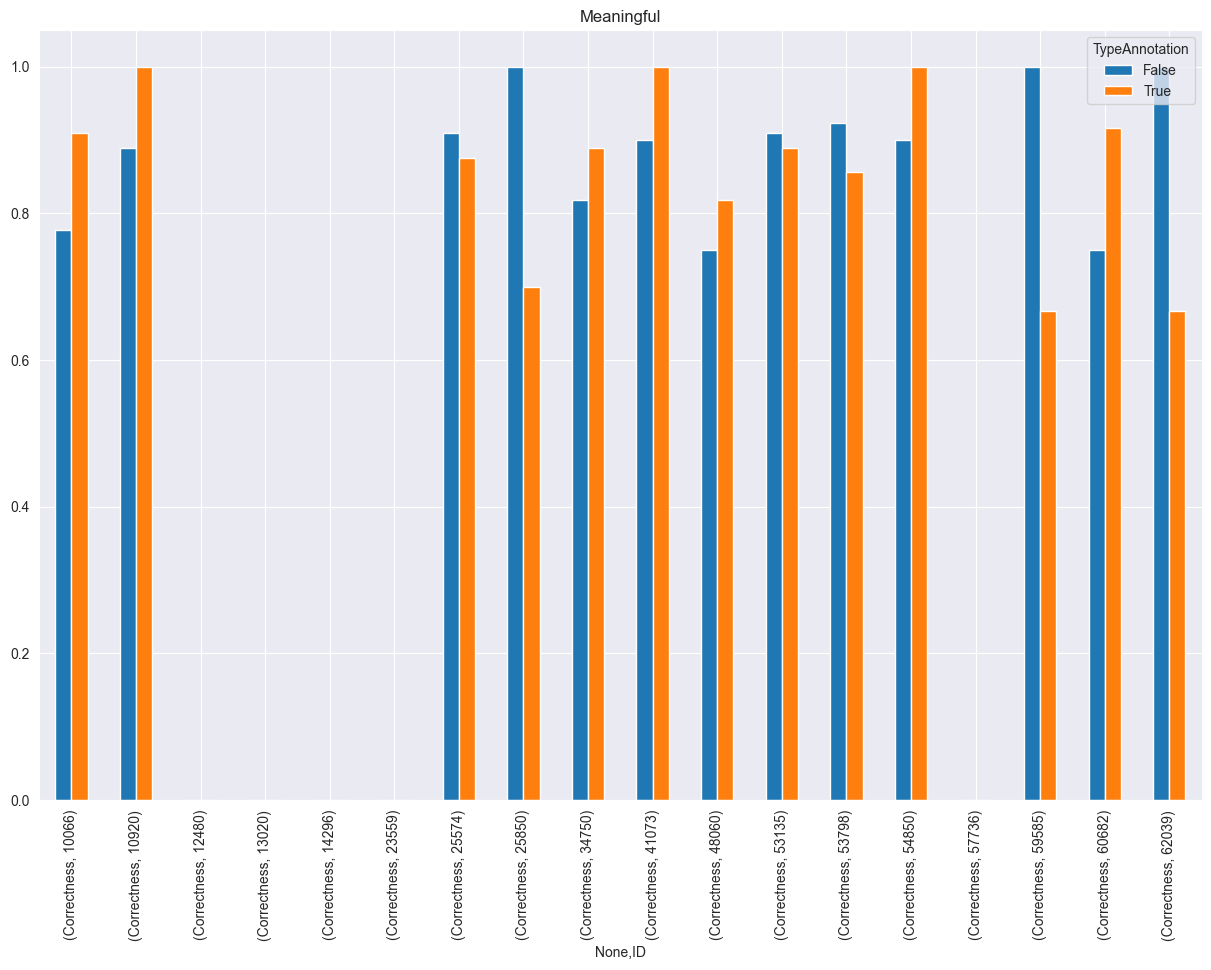

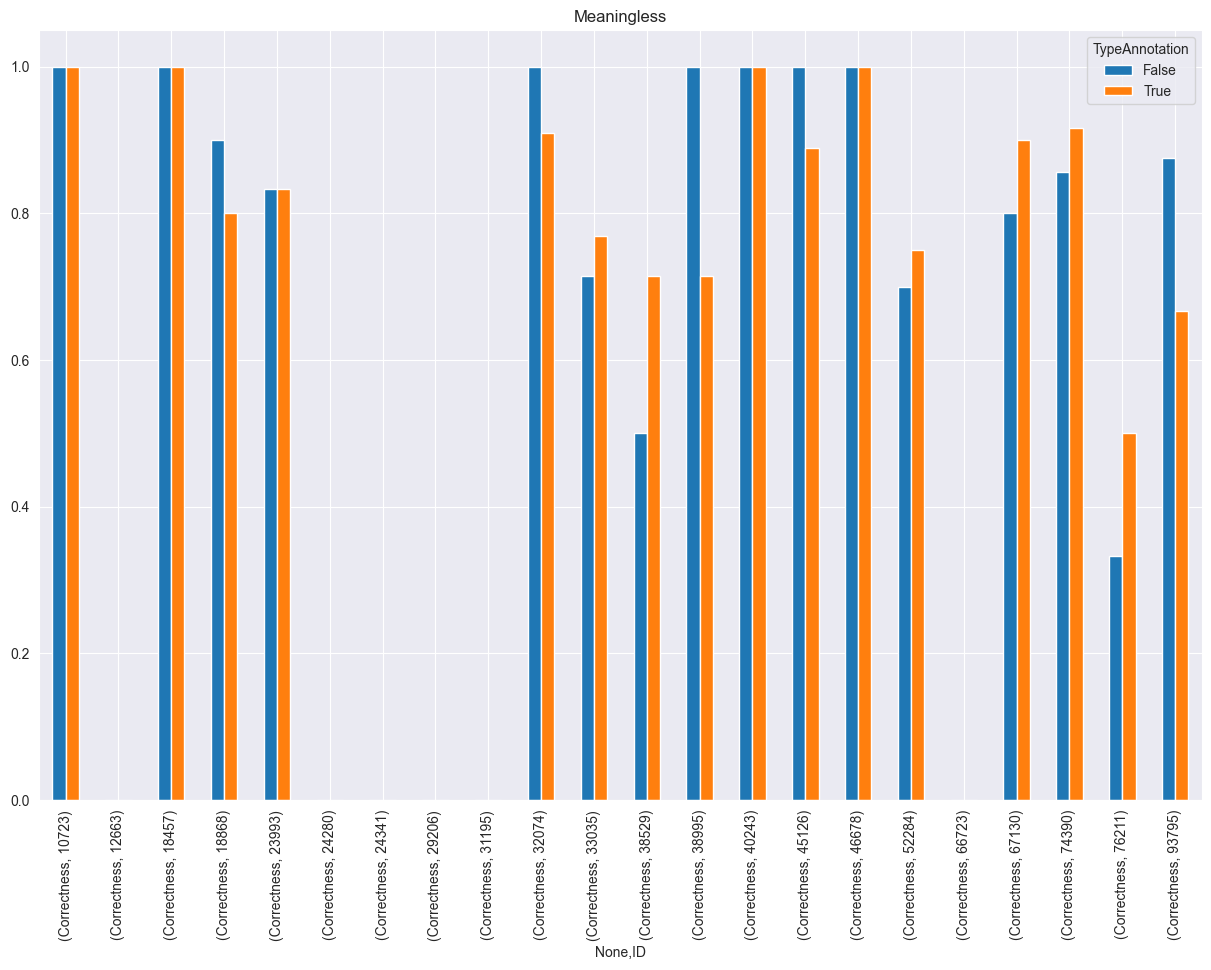

In [95]:
correctness_df_by_participant_meaningful: DataFrame = DataFrame(columns=['ID', 'Correctness', 'TypeAnnotation'])
correctness_df_by_participant_meaningless: DataFrame = DataFrame(columns=['ID', 'Correctness', 'TypeAnnotation'])


counter: int = 0
for participant in meaningful_participants:
    correct_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].sum()
    correct_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].sum()

    total_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].count()
    total_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].count()

    correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
    correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]

    counter += 2

counter = 0
for participant in meaningless_participants:
    correct_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].sum()
    correct_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].sum()

    total_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['CorrectAnswer'].count()
    total_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['CorrectAnswer'].count()

    correctness_df_by_participant_meaningless.loc[counter] = [participant, correct_TA / total_TA, True]
    correctness_df_by_participant_meaningless.loc[counter + 1] = [participant, correct_L / total_L, False]

    counter += 2

correctness_df_by_participant_meaningful.groupby(['TypeAnnotation', 'ID']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10), title="Meaningful")

correctness_df_by_participant_meaningless.groupby(['TypeAnnotation', 'ID']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10), title="Meaningless")
plt.show()

Check for the time and correct answers per code snippet.

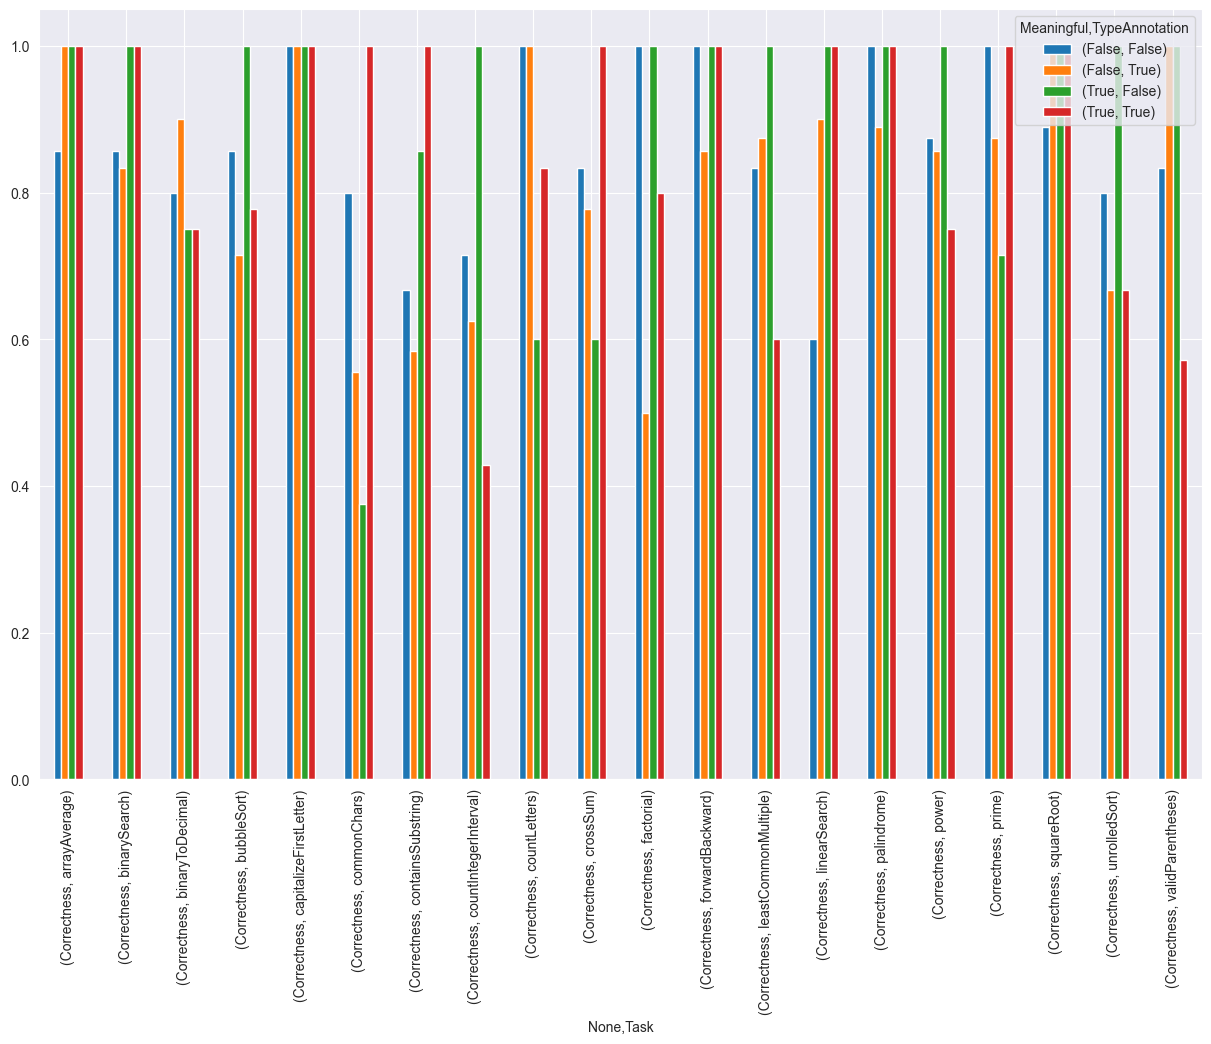

In [96]:
snippet_correctness_df.groupby(['Meaningful', 'TypeAnnotation', 'Task']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10))

plt.show()

### Difficulty Rating

First let's check how the difficulty is for each task. I think this would be best as a table?

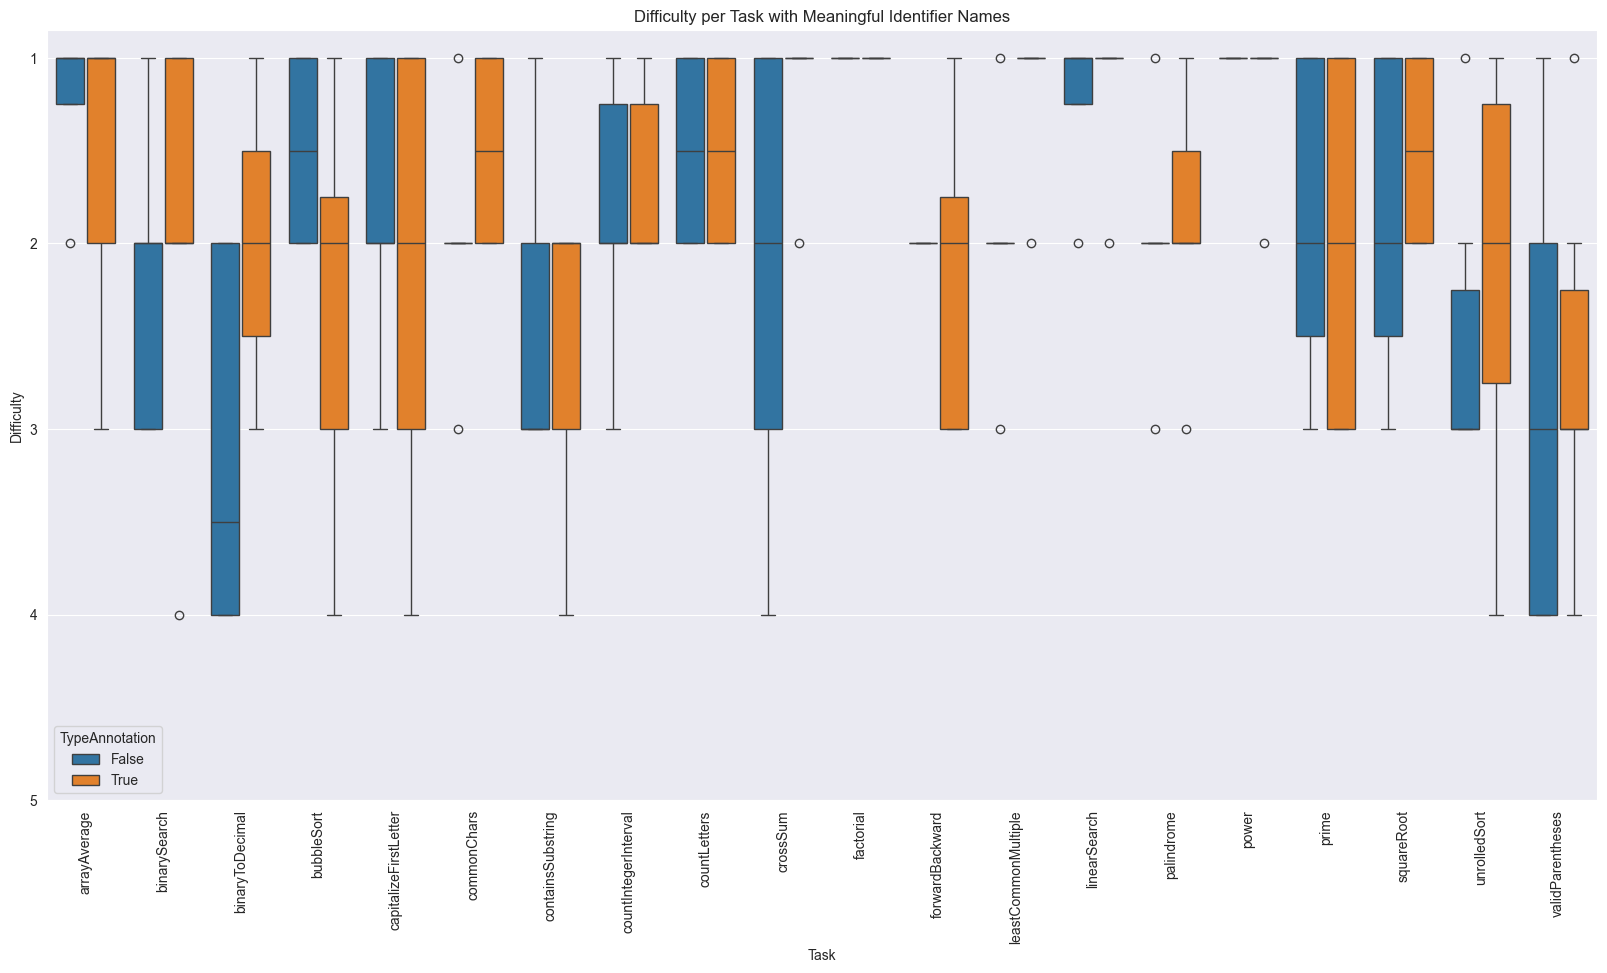

In [97]:
plt.figure(figsize=(20, 10))
sns.boxplot(df_results_overall.query(f'`Meaningful` == True'), x='Task', y='Difficulty', hue='TypeAnnotation', 
            gap=.1, 
            # inner="quart", 
            # cut=0, 
            order=all_tasks,
            # split=True,
            )

plt.xticks(all_tasks, rotation=90)
plt.yticks(np.arange(1, 6, 1))
plt.title('Difficulty per Task with Meaningful Identifier Names') 

plt.show()

And now with meaningless identifier names.

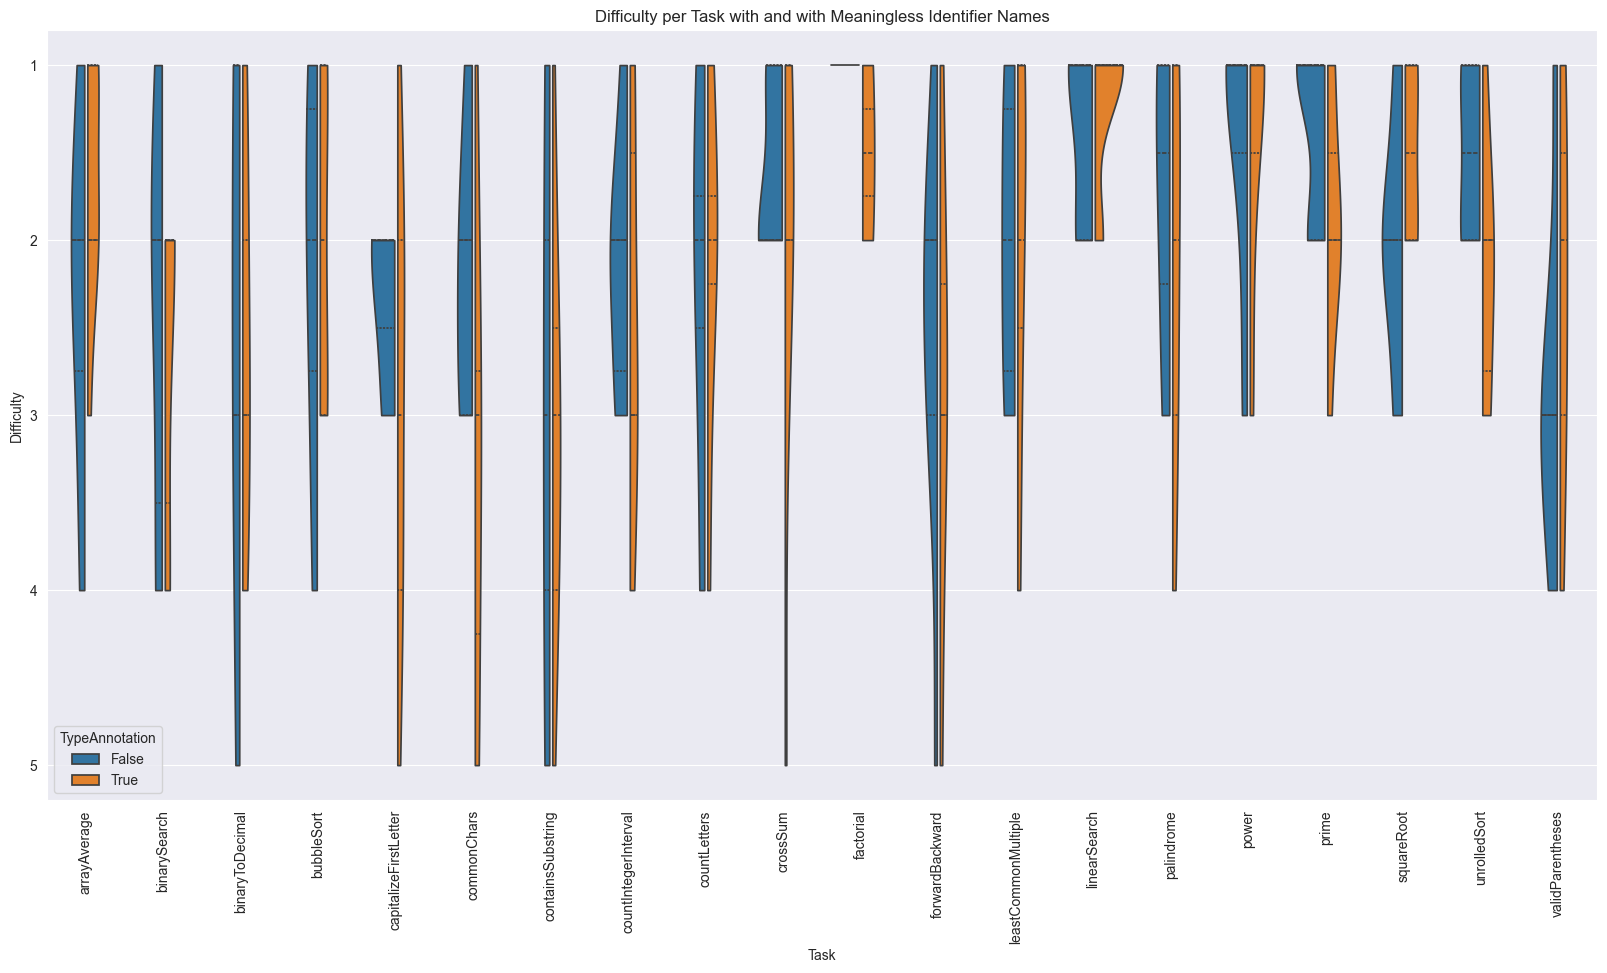

In [98]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == False'), x='Task', y='Difficulty',
               hue='TypeAnnotation', 
            gap=.1, 
            inner="quart", 
            cut=0, 
            order=all_tasks,
            split=True,
            )

plt.xticks(all_tasks, rotation=90)
plt.yticks(np.arange(1, 6, 1))
plt.title('Difficulty per Task with and with Meaningless Identifier Names') 

plt.show()

The difficulty that each participant felt.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/3676903804.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/3676903804.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=m

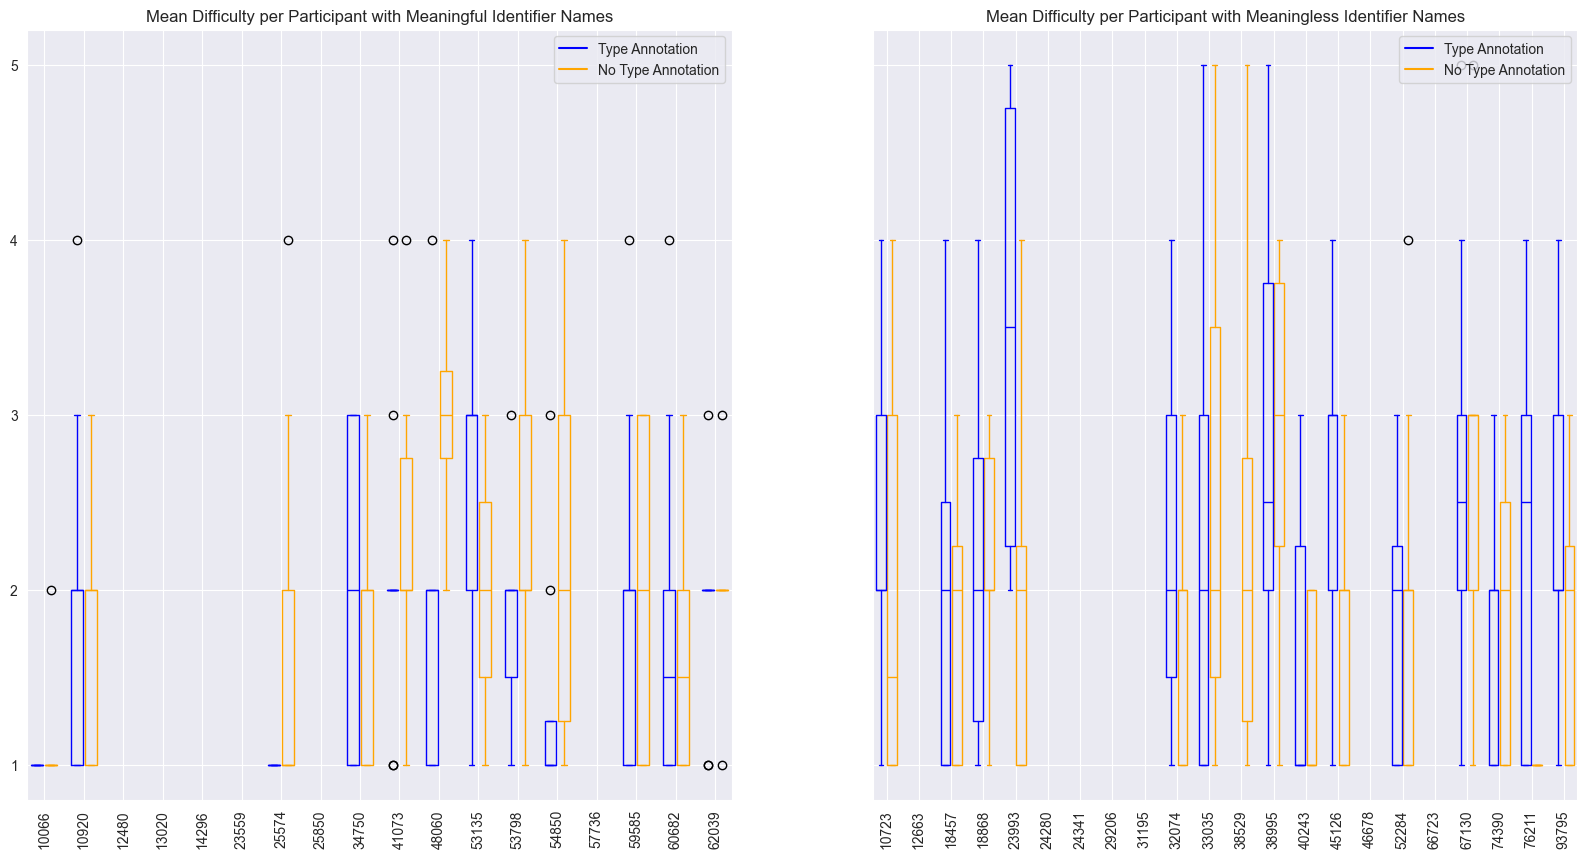

In [99]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), sharey=True)

# first plot
plot_L_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0+0.35, widths=0.6)
plot_TA_M = axs[0].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Difficulty'] for participant in meaningful_participants], labels=meaningful_participants, positions=np.arange(len(meaningful_participants))*2.0-0.35, widths=0.6)

# first plot settings
axs[0].set_title('Mean Difficulty per Participant with Meaningful Identifier Names')
axs[0].set_xticks(np.arange(0, len(meaningful_participants) * 2, 2), meaningful_participants, rotation=90)
axs[0].set_yticks(np.arange(1, 6, 1))
define_box_properties(plot_TA_M, 'blue', 'Type Annotation', axs[0])
define_box_properties(plot_L_M, 'orange', 'No Type Annotation', axs[0])

# second plot
plot_L_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == False')['Difficulty'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0+0.35, widths=0.6)
plot_TA_L = axs[1].boxplot([df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == False')['Difficulty'] for participant in meaningless_participants], labels=meaningless_participants, positions=np.arange(len(meaningless_participants))*2.0-0.35, widths=0.6)

# second plot settings
axs[1].set_title('Mean Difficulty per Participant with Meaningless Identifier Names')
axs[1].set_xticks(np.arange(0, len(meaningless_participants) * 2, 2), meaningless_participants, rotation=90)
axs[1].set_yticks(np.arange(1, 6, 1))
define_box_properties(plot_TA_L, 'blue', 'Type Annotation', axs[1])
define_box_properties(plot_L_L, 'orange', 'No Type Annotation', axs[1])

plt.show()


Correct Answer by Difficulty

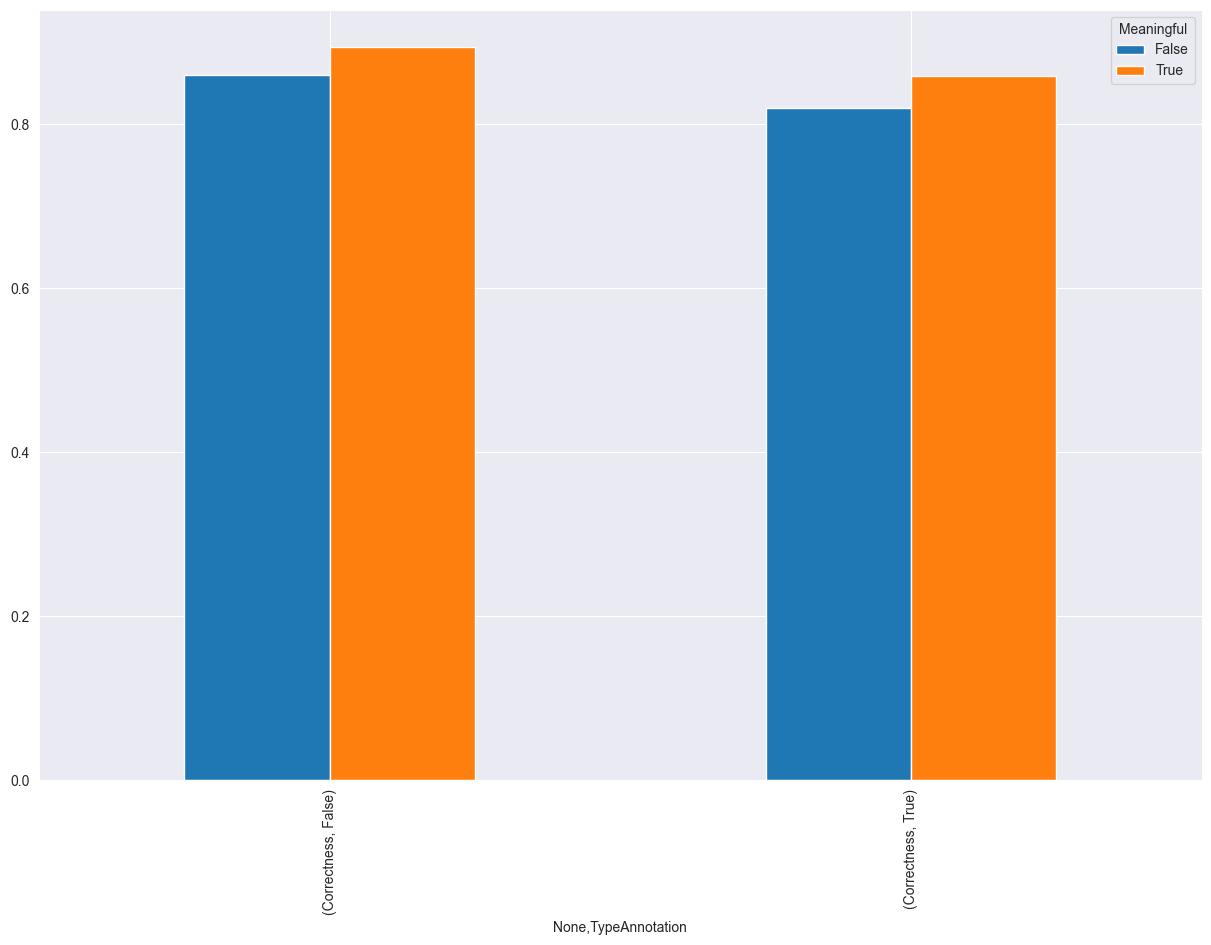

In [100]:
snippet_correctness_df.groupby(['Meaningful', 'TypeAnnotation']).agg({'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10))

plt.show()

Difficulty count by snippet

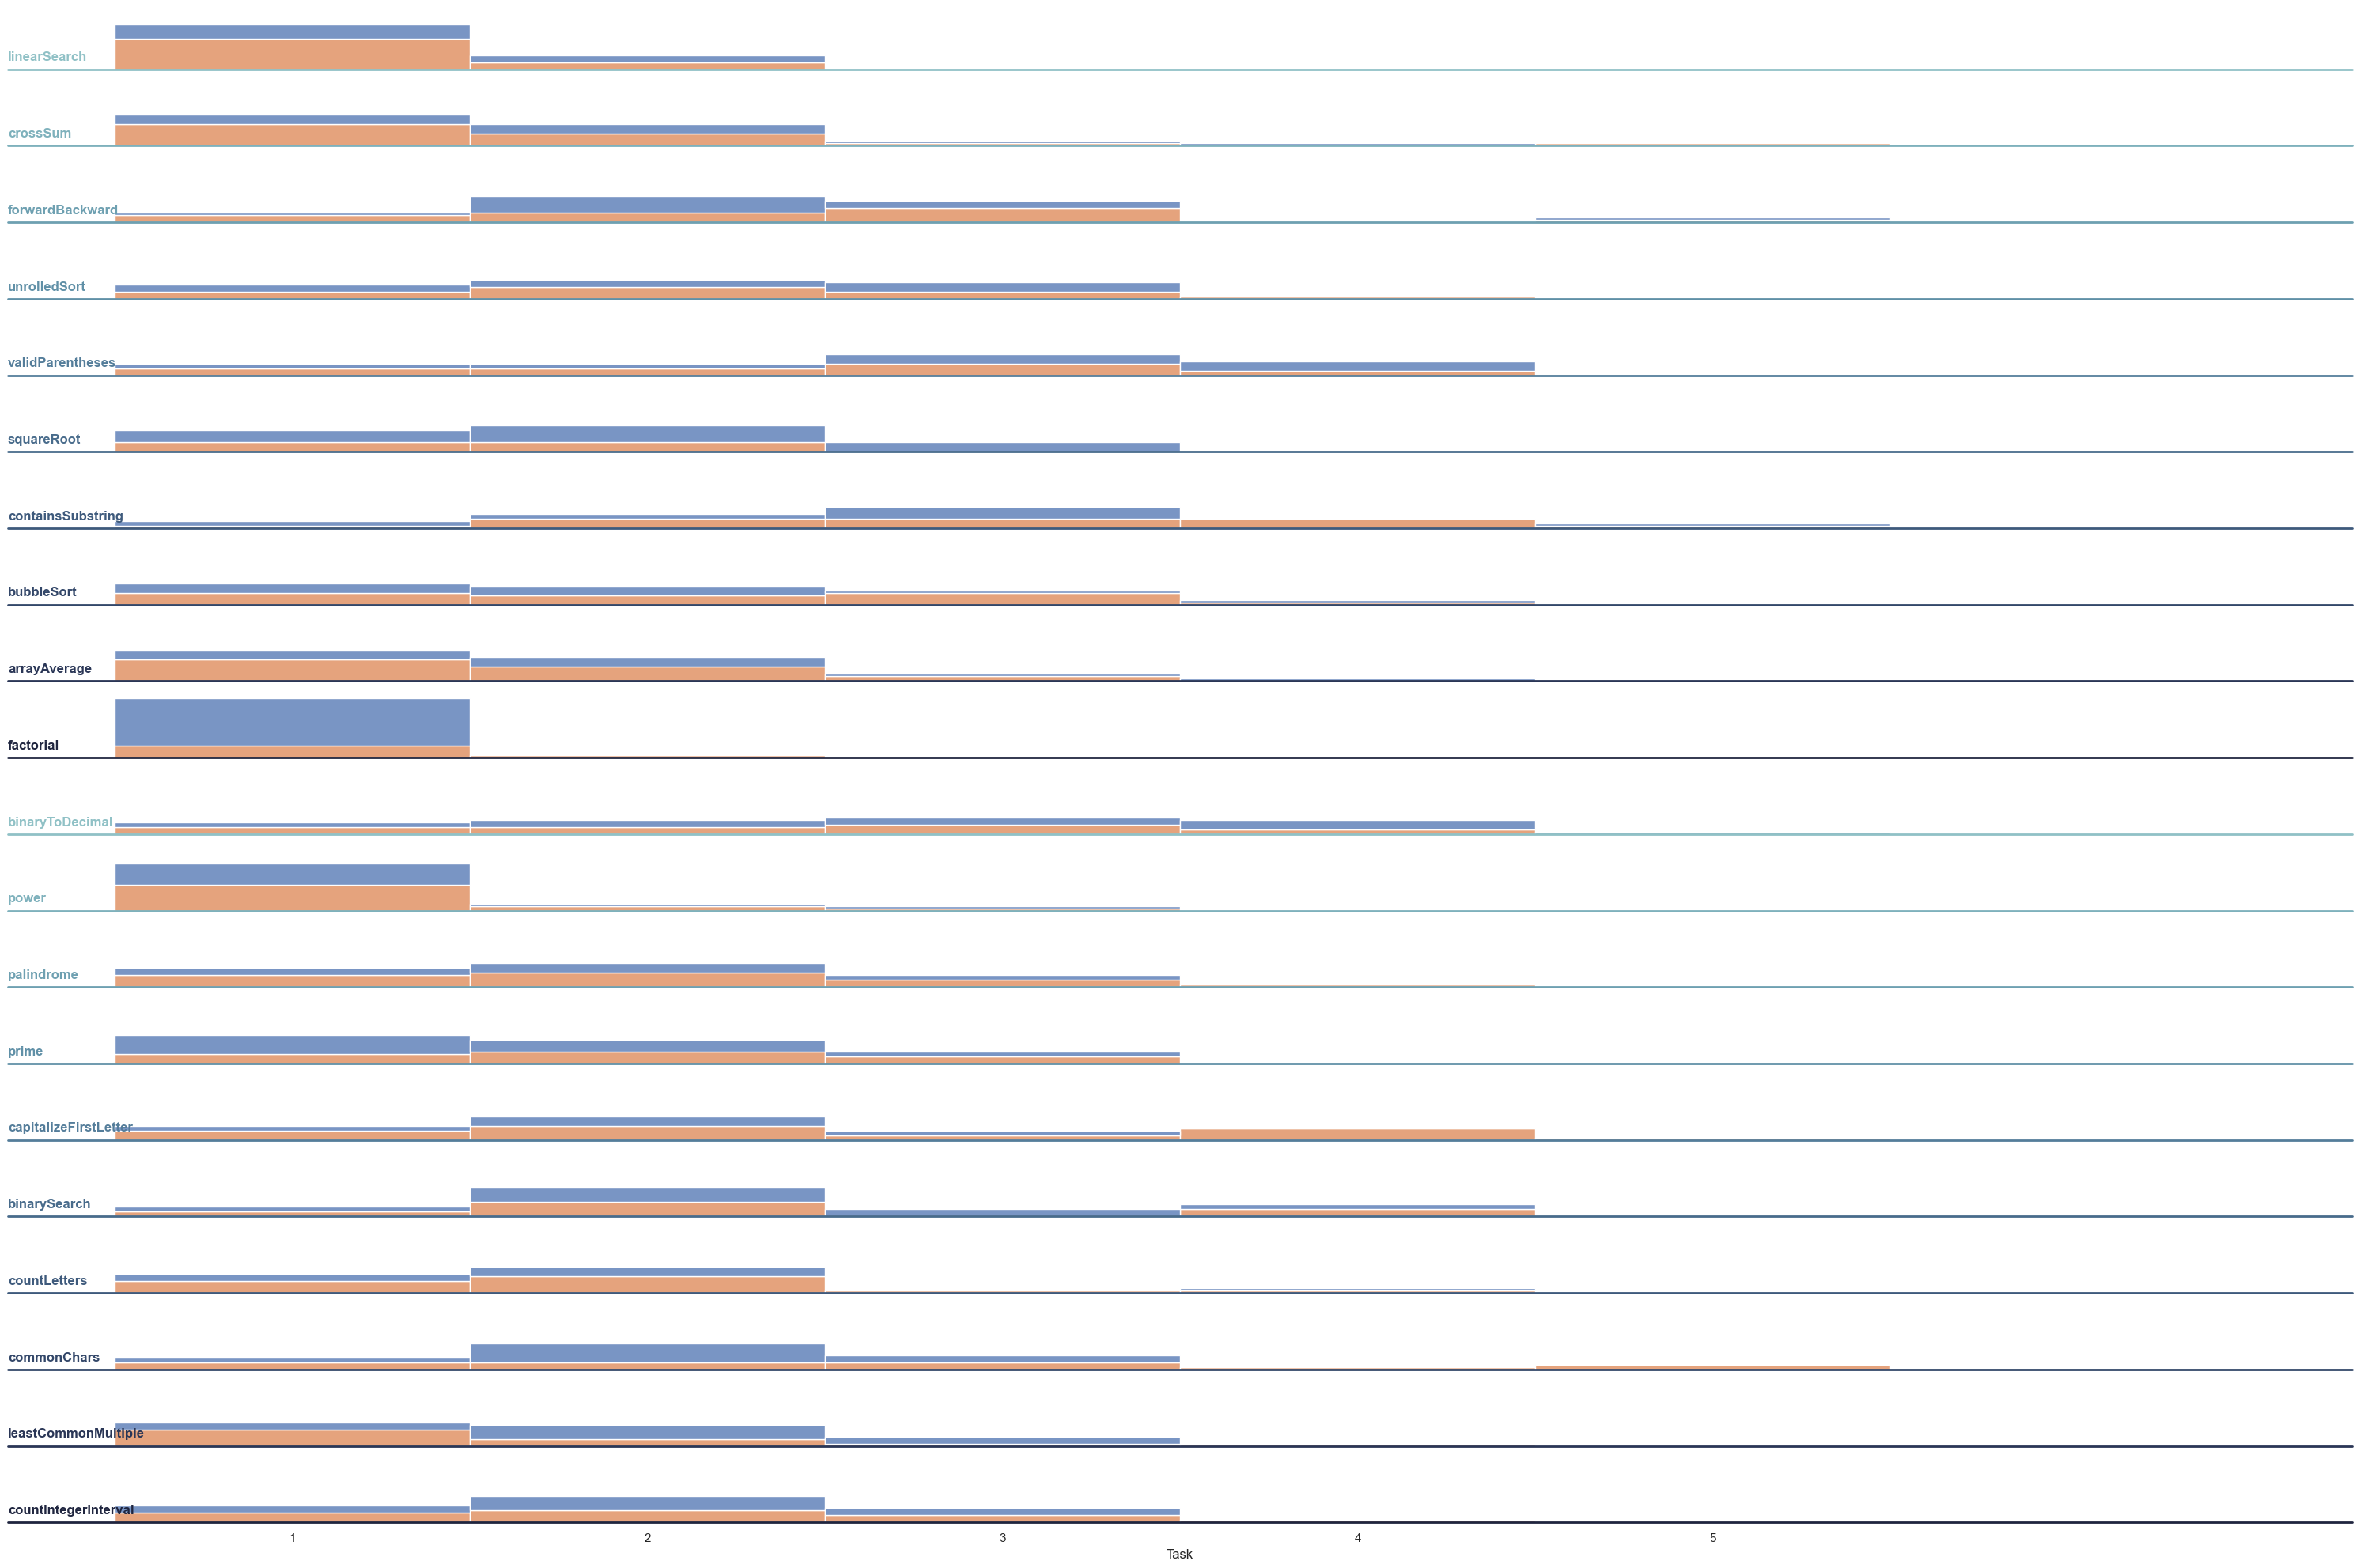

In [101]:
sns.set_theme(style="white")
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(df_results_overall, row="Task", 
                #   col="Type Annotation",
                  hue="Task", 
                  height=1, 
                  aspect=30, 
                  palette=pal,
                  )
g.map_dataframe(sns.histplot, x="Difficulty", hue="TypeAnnotation", binwidth=1, binrange=(1, 6), multiple="stack")
# g.map_dataframe(sns.kdeplot, x="Difficulty", clip=(1, 5), fill=True)
# g.map_dataframe(sns.kdeplot, x="Difficulty", hue='Type Annotation', clip_on=(1, 5), color="black", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "Task")
g.figure.subplots_adjust(hspace=-.5)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xticks=np.arange(1, 6, 1))
g.despine(bottom=True, left=True)

g.figure.tight_layout()


## Display META Data

In [102]:
# if the line 'Total' does not exist, create it
if not 'Total' in df_meta_data.index:
    df_meta_data.loc['Total'] = df_meta_data[[col for col in meta_data_columns if col not in unnecessary_columns_meta_data]].sum()
    # add the number of times a participant did not finish all snippets to the 'Total' line
    df_meta_data.loc['Total','NumberOfMissingSnippets'] = df_meta_data.groupby('ID')['NumberOfMissingSnippets'].any().value_counts()[True]
    # df_meta_data.loc['Total']['NumberOfMissingSnippets'] = df_meta_data['NumberOfMissingSnippets'].any()
    df_meta_data = df_meta_data.fillna('')

# set the background color of the dataframe value to red if the value is False
df_meta_data.style.applymap(lambda x: 'background-color: darkred' if x == False else '')

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_90319/167980355.py:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_meta_data.style.applymap(lambda x: 'background-color: darkred' if x == False else '')


,ID,GazeDataFilled,InterviewData,OverallTime,Meaningful,Finished,NumberOfMissingSnippets,PersonalInformation,ResultsOverall
0,10066,,,,1,True,0,True,True
1,10723,,,,0,True,0,True,True
2,10920,,,,1,True,0,True,True
3,12480,,,,1,True,0,True,True
4,12663,,,,0,False,8,True,True
7,18457,,,,0,True,0,True,True
8,18868,,,,0,False,3,True,True
10,23993,,,,0,False,1,True,True
11,24280,,,,0,True,0,True,True
13,25574,,,,1,False,12,True,True


### Overview

The corrected p-values for the mixed linear regression models.

In [103]:

# Example p-values
p_values = np.array([0.43, 0.033, 0.056, 0.031, 0.33, 0.1, 0.55, 0.97])

# Perform Benjamini-Hochberg FDR correction
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# Output the results
print("Original p-values:", p_values)
print("Corrected p-values:", pvals_corrected)
print("Rejected hypotheses:", rejected)

Original p-values: [0.43  0.033 0.056 0.031 0.33  0.1   0.55  0.97 ]
Corrected p-values: [0.57333333 0.132      0.14933333 0.132      0.528      0.2
 0.62857143 0.97      ]
Rejected hypotheses: [False False False False False False False False]
